In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Market Functions

def CPMM_Price(X, Y, D):
    
    return X/(Y-D)

def CPMM_Marginal_Price(X, Y):
    
    return X/Y

def CPMM_Update(X, Y, D):
    
    P = CPMM_Price(X, Y, D)
    
    return [X + P * D, Y - D]

# def CEX_Price_Update(S, mu, sigma, dt, dW):
    
#     return S + kappa * (mu - S) * dt + sigma * np.sqrt(S) * dW

def Arb_Trade_CPMM(S, X, Y, eta0, eta1, M=1):
    
    D_A = np.zeros(M)
    
    P = CPMM_Marginal_Price(X, Y)
    
    q1 = np.minimum(Y * (1 - np.sqrt((P * (1 - eta1))/(S * (1 + eta0)))), 0.)
    q2 = np.maximum(Y * (1 - np.sqrt((P * (1 + eta1))/(S * (1 - eta0)))), 0.)
    
    D_A = q1 + q2
    
    return D_A

def Buy_Trade_CPMM(buy, S, X, Y, eta0, eta1):
    
    P = CPMM_Marginal_Price(X, Y)
    
    v = Y * (1 - np.sqrt((P * (1 + eta1))/(S * (1 + eta0))))
    
    return np.maximum(np.minimum(buy, v), 0.)
        
def Sell_Trade_CPMM(sell, S, X, Y, eta0, eta1):
    
    P = CPMM_Marginal_Price(X, Y)
    
    v = Y * (1 - np.sqrt((P * (1 - eta1))/(S * (1 - eta0))))

    return np.minimum(np.maximum(sell, v), 0.)

In [3]:
import pandas as pd

In [4]:
df_init_0 = pd.read_csv('data/USDCUSDT/USDCUSDT-1m-2024-08-25.csv')
df_init_0.columns=['time', 'open', 'high', 'low', 'close', 's1', 's2', 's3', 's4', 's5', 's6', 's7']
df_init_0.set_index('time', inplace=True)
df_init_0.index = pd.to_datetime(df_init_0.index, unit='ms')
df_init_0

,open,high,low,close,s1,s2,s3,s4,s5,s6,s7
time,,,,,,,,,,,
2024-08-25 00:01:00,0.9995,0.9995,0.9994,0.9995,127745.0,1724544119999,1.276790e+05,269,106428.0,1.063748e+05,0
2024-08-25 00:02:00,0.9994,0.9995,0.9994,0.9995,117270.0,1724544179999,1.172106e+05,178,109412.0,1.093573e+05,0
2024-08-25 00:03:00,0.9995,0.9995,0.9994,0.9995,342526.0,1724544239999,3.423522e+05,267,317311.0,3.171523e+05,0
2024-08-25 00:04:00,0.9995,0.9995,0.9994,0.9995,63144.0,1724544299999,6.311223e+04,133,61193.0,6.116240e+04,0
2024-08-25 00:05:00,0.9994,0.9995,0.9994,0.9994,2000330.0,1724544359999,1.999318e+06,677,1879608.0,1.878668e+06,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-25 23:55:00,0.9995,0.9995,0.9994,0.9995,160704.0,1724630159999,1.606220e+05,111,144547.0,1.444747e+05,0
2024-08-25 23:56:00,0.9995,0.9995,0.9994,0.9995,142849.0,1724630219999,1.427768e+05,139,135571.0,1.355032e+05,0
2024-08-25 23:57:00,0.9995,0.9995,0.9994,0.9994,48648.0,1724630279999,4.862275e+04,86,39415.0,3.939529e+04,0


In [5]:
df_0 = df_init_0[['close']].copy()
df_0

,close
time,
2024-08-25 00:01:00,0.9995
2024-08-25 00:02:00,0.9995
2024-08-25 00:03:00,0.9995
2024-08-25 00:04:00,0.9995
2024-08-25 00:05:00,0.9994
...,...
2024-08-25 23:55:00,0.9995
2024-08-25 23:56:00,0.9995
2024-08-25 23:57:00,0.9994


In [6]:
def simulation_realprice(N_, T_, dt_, prices_array, buy_, sell_, noise_, eta0_, eta1_, X_, Y_, seed=42):

    np.random.seed(seed)
    # Initialize Vectors
    
    M = np.shape(prices_array)[0]
    N = N_# Number of periods
    
    
    Pool_X = np.zeros((N+1, M)) # Time series for X pool reserves
    Pool_Y = np.zeros((N+1, M)) # Time series for Y pool reserves
    S0 = prices_array.T
    S_ = S0[0]
    S1 = np.zeros((N+1, M)) # Time series for CPMM price
    Arb = np.zeros((N+1, M)) # Time series of arbitrageur transactions
    CPMM_buy = np.zeros((N+1, M)) # Time series for systematic purchases on CPMM
    CPMM_sell = np.zeros((N+1, M)) # Time series for systematic sales on CPMM
    CPMM_noise = np.zeros((N+1, M)) # Time series for systematic net zero noise volume on CPMM
    CPMM_buy_revenue = np.zeros((N+1, M)) # Time series for buy trade revenue
    CPMM_sell_revenue = np.zeros((N+1, M)) # Time series for sell trade revenue
    CPMM_arb_revenue = np.zeros((N+1, M)) # Time series for arbitrage trade revenue
    CPMM_noise_revenue = np.zeros((N+1, M)) # Time series for noise trade revenue
    tracking_port_val = np.zeros((N+1, M)) # Time series for tracking portfolio value
    
    avg_buy_fee_rev = 0
    avg_sell_fee_rev = 0
    avg_arb_fee_rev = 0
    avg_imp_loss = 0
    avg_buy_volume = 0 
    avg_sell_volume = 0
    avg_arb_volume = 0
    avg_noise_fee_rev = 0
    avg_noise_volume = 0
            
    T = T_ # Time horizon
    dt = dt_ # Time increment
    buy = buy_ # Constant trade size for systematic buyers
    sell = sell_ # Constant trade size for systematic sellers
    eta0 = eta0_ # CEX proportional cost
    eta1 = eta1_ # CPMM proportional cost
    S = S_*np.ones(M) # Initial CEX Price
    X = X_*np.ones(M) # Initial CPMM Dollar Reserves
    Y = Y_*np.ones(M) # Initial CPMM Asset Reserves
    D_N = noise_

    S1[0] = CPMM_Marginal_Price(X, Y)
    Pool_X[0] = X
    Pool_Y[0] = Y
    tracking_port_val[0] = Pool_X[0] + Pool_Y[0] * S0[0]
    
    dWs = np.sqrt(dt) * np.random.normal(0., 1., size=(N, M))
        
    uni = np.random.uniform(0, 1, size=(N+1, M))
    filtr_bfs = uni < 0.5
    filtr_sfs = uni >= 0.5

    for i in range(1,N+1):

        S = S0[i]

        S1[i] = CPMM_Marginal_Price(X, Y)
        Pool_X[i] = X
        Pool_Y[i] = Y

        D_A = Arb_Trade_CPMM(S, X, Y, eta0, eta1, M)

        P = CPMM_Price(X, Y, D_A)

        [X, Y] = CPMM_Update(X, Y, D_A)

        S1[i] = CPMM_Marginal_Price(X, Y)
        Pool_X[i] = X
        Pool_Y[i] = Y
        Arb[i] = D_A 
        CPMM_arb_revenue[i] = np.abs(D_A * P * eta1)

            
        filtr_bf = filtr_bfs[i]
        filtr_sf = filtr_sfs[i]

        S_bf = S[filtr_bf]
        X_bf = X[filtr_bf]
        Y_bf = Y[filtr_bf]

        D_B = Buy_Trade_CPMM(buy, S_bf, X_bf, Y_bf, eta0, eta1)

        P = CPMM_Price(X_bf, Y_bf, D_B)

        [X_bf, Y_bf] = CPMM_Update(X_bf, Y_bf, D_B)

        S1[i, filtr_bf] = CPMM_Marginal_Price(X_bf, Y_bf)
        X[filtr_bf] = X_bf.copy()
        Y[filtr_bf] = Y_bf.copy()
        Pool_X[i, filtr_bf] = X_bf.copy()
        Pool_Y[i, filtr_bf] = Y_bf.copy()
        CPMM_buy[i, filtr_bf] = D_B
        CPMM_buy_revenue[i, filtr_bf] = D_B * P * eta1

        S_sf = S[filtr_sf]
        X_sf = X[filtr_sf]
        Y_sf = Y[filtr_sf]

        D_S = Sell_Trade_CPMM(sell, S_sf, X_sf, Y_sf, eta0, eta1)

        P = CPMM_Price(X_sf, Y_sf, D_S)

        [X_sf, Y_sf] = CPMM_Update(X_sf, Y_sf, D_S)

        S1[i, filtr_sf] = CPMM_Marginal_Price(X_sf, Y_sf)
        X[filtr_sf] = X_sf.copy()
        Y[filtr_sf] = Y_sf.copy()
        Pool_X[i, filtr_sf] = X_sf.copy()
        Pool_Y[i, filtr_sf] = Y_sf.copy()
        CPMM_sell[i, filtr_sf] = D_S
        CPMM_sell_revenue[i, filtr_sf] = -1 * D_S * P * eta1


        S_bf = S[filtr_bf]
        X_bf = X[filtr_bf]
        Y_bf = Y[filtr_bf]

        D_S = Sell_Trade_CPMM(sell, S_bf, X_bf, Y_bf, eta0, eta1)

        P = CPMM_Price(X_bf, Y_bf, D_S)

        [X_bf, Y_bf] = CPMM_Update(X_bf, Y_bf, D_S)

        S1[i, filtr_bf] = CPMM_Marginal_Price(X_bf, Y_bf)
        X[filtr_bf] = X_bf.copy()
        Y[filtr_bf] = Y_bf.copy()
        Pool_X[i, filtr_bf] = X_bf.copy()
        Pool_Y[i, filtr_bf] = Y_bf.copy()
        CPMM_sell[i, filtr_bf] = D_S
        CPMM_sell_revenue[i, filtr_bf] = -1 * D_S * P * eta1

        S_sf = S[filtr_sf]
        X_sf = X[filtr_sf]
        Y_sf = Y[filtr_sf]

        D_B = Buy_Trade_CPMM(buy, S_sf, X_sf, Y_sf, eta0, eta1)

        P = CPMM_Price(X_sf, Y_sf, D_B)

        [X_sf, Y_sf] = CPMM_Update(X_sf, Y_sf, D_B)

        S1[i, filtr_sf] = CPMM_Marginal_Price(X_sf, Y_sf)
        X[filtr_sf] = X_sf.copy()
        Y[filtr_sf] = Y_sf.copy()
        Pool_X[i, filtr_sf] = X_sf.copy()
        Pool_Y[i, filtr_sf] = Y_sf.copy()
        CPMM_buy[i, filtr_sf] = D_B
        CPMM_buy_revenue[i, filtr_sf] = D_B * P * eta1
        
        
        # Noise revenue (Assume 0 net volume and instantaneous transactions at the marginal price)
        CPMM_noise_revenue[i] = S1[i] * eta1 * D_N
        CPMM_noise[i] = D_N * np.ones(M)
        
        tracking_port_val[i] = tracking_port_val[i-1] + Pool_Y[i-1] * (S0[i]-S0[i-1])


    avg_buy_fee_rev = np.mean(np.sum(CPMM_buy_revenue, axis=0))
    avg_sell_fee_rev = np.mean(np.sum(CPMM_sell_revenue, axis=0))
    avg_arb_fee_rev = np.mean(np.sum(CPMM_arb_revenue, axis=0))
    avg_term_val = np.mean(Pool_X[-1] + Pool_Y[-1] * S0[-1])
    avg_init_val = np.mean(Pool_X[0] + Pool_Y[0] * S0[0])
    avg_mtm_init_holdings = np.mean(Pool_X[0] + Pool_Y[0] * S0[-1])
    avg_tracking_val = np.mean(tracking_port_val[-1])
    avg_imp_loss = np.mean(Pool_X[-1] + Pool_Y[-1] * S0[-1] - Pool_X[0] - Pool_Y[0] * S0[-1])
    avg_buy_volume = np.mean(np.sum(CPMM_buy, axis=0))
    avg_sell_volume = np.mean(np.sum(CPMM_sell, axis=0))
    avg_arb_volume = np.mean(np.sum(np.abs(Arb), axis=0))
    avg_noise_volume = np.mean(np.sum(CPMM_noise, axis=0))
    avg_noise_fee_rev = np.mean(np.sum(CPMM_noise_revenue,axis=0))
    mean_end_price = np.mean(S0[-1])
    mean_amm_end_price = np.mean(S1[-1])
    mean_y = np.mean(Pool_Y[-1])
    mean_x = np.mean(Pool_X[-1])
    mean_ys = np.mean(Pool_Y[-1] * S0[-1])
    
    return np.array([avg_buy_fee_rev, avg_sell_fee_rev, avg_arb_fee_rev, avg_imp_loss, 
                     avg_buy_volume, avg_sell_volume, avg_arb_volume, mean_end_price,
                     mean_amm_end_price,mean_y,mean_x,mean_ys,
                     avg_term_val,avg_init_val,avg_mtm_init_holdings,avg_tracking_val,
                    avg_noise_fee_rev, avg_noise_volume])

In [7]:
# Market Parameters

T = 1 # Time horizon
N = np.shape(df_0['close'].values)[0]-1 # Number of periods
dt = T/N # Time increment
buy = 250.*dt # Constant trade size for systematic buyers
sell = -250.*dt # Constant trade size for systematic sellers
noise = 25.*dt # Constant net zero noise trade size
eta0 = 0.01 # CEX proportional cost
eta1 = 0.005 # CPMM proportional cost
X = 1000000 # Initial CPMM Dollar Reserves
Y = 1000000 # Initial CPMM Asset Reserves

In [8]:
pa_0 = np.array([df_0['close'].values])

In [9]:
%%time 

simulation_realprice(N, T, dt, pa_0, buy, sell, noise, eta0, eta1, X, Y)

CPU times: user 229 ms, sys: 2.88 ms, total: 232 ms
Wall time: 232 ms


array([ 1.2500e+00,  1.2500e+00,  0.0000e+00,  0.0000e+00,  2.5000e+02,
       -2.5000e+02,  0.0000e+00,  9.9940e-01,  1.0000e+00,  1.0000e+06,
        1.0000e+06,  9.9940e+05,  1.9994e+06,  1.9995e+06,  1.9994e+06,
        1.9994e+06,  1.2500e-01,  2.5000e+01])

In [10]:
buy

0.17385257301808066

In [11]:
# Check number of threads
multiprocessing.cpu_count()

8

In [12]:
# Parallel For Loop Parameters
eta1_vals = np.array([i*0.0002 for i in range(0,101)]) # Set of possible eta values
eta1_vals

array([0.    , 0.0002, 0.0004, 0.0006, 0.0008, 0.001 , 0.0012, 0.0014,
       0.0016, 0.0018, 0.002 , 0.0022, 0.0024, 0.0026, 0.0028, 0.003 ,
       0.0032, 0.0034, 0.0036, 0.0038, 0.004 , 0.0042, 0.0044, 0.0046,
       0.0048, 0.005 , 0.0052, 0.0054, 0.0056, 0.0058, 0.006 , 0.0062,
       0.0064, 0.0066, 0.0068, 0.007 , 0.0072, 0.0074, 0.0076, 0.0078,
       0.008 , 0.0082, 0.0084, 0.0086, 0.0088, 0.009 , 0.0092, 0.0094,
       0.0096, 0.0098, 0.01  , 0.0102, 0.0104, 0.0106, 0.0108, 0.011 ,
       0.0112, 0.0114, 0.0116, 0.0118, 0.012 , 0.0122, 0.0124, 0.0126,
       0.0128, 0.013 , 0.0132, 0.0134, 0.0136, 0.0138, 0.014 , 0.0142,
       0.0144, 0.0146, 0.0148, 0.015 , 0.0152, 0.0154, 0.0156, 0.0158,
       0.016 , 0.0162, 0.0164, 0.0166, 0.0168, 0.017 , 0.0172, 0.0174,
       0.0176, 0.0178, 0.018 , 0.0182, 0.0184, 0.0186, 0.0188, 0.019 ,
       0.0192, 0.0194, 0.0196, 0.0198, 0.02  ])

In [13]:
df_init_1 = pd.read_csv('data/USDCUSDT/USDCUSDT-1m-2024-07-25.csv')
df_init_1.columns=['time', 'open', 'high', 'low', 'close', 's1', 's2', 's3', 's4', 's5', 's6', 's7']
df_init_1.set_index('time', inplace=True)
df_init_1.index = pd.to_datetime(df_init_1.index, unit='ms')
df_1 = df_init_1[['close']].copy()
pa_1 = np.array([df_1['close'].values])


In [14]:
df_init_2 = pd.read_csv('data/USDCUSDT/USDCUSDT-1m-2024-05-25.csv')
df_init_2.columns=['time', 'open', 'high', 'low', 'close', 's1', 's2', 's3', 's4', 's5', 's6', 's7']
df_init_2.set_index('time', inplace=True)
df_init_2.index = pd.to_datetime(df_init_2.index, unit='ms')
df_2 = df_init_2[['close']].copy()
pa_2 = np.array([df_2['close'].values])
pa_2[-1] = pa_2[0]

In [15]:
pa_0 /= (pa_0[0,0])
pa_1 /= (pa_1[0,0])
pa_2 /= (pa_2[0,0])

In [16]:
plt.show()
plt.rcParams["figure.figsize"] = [16, 9]

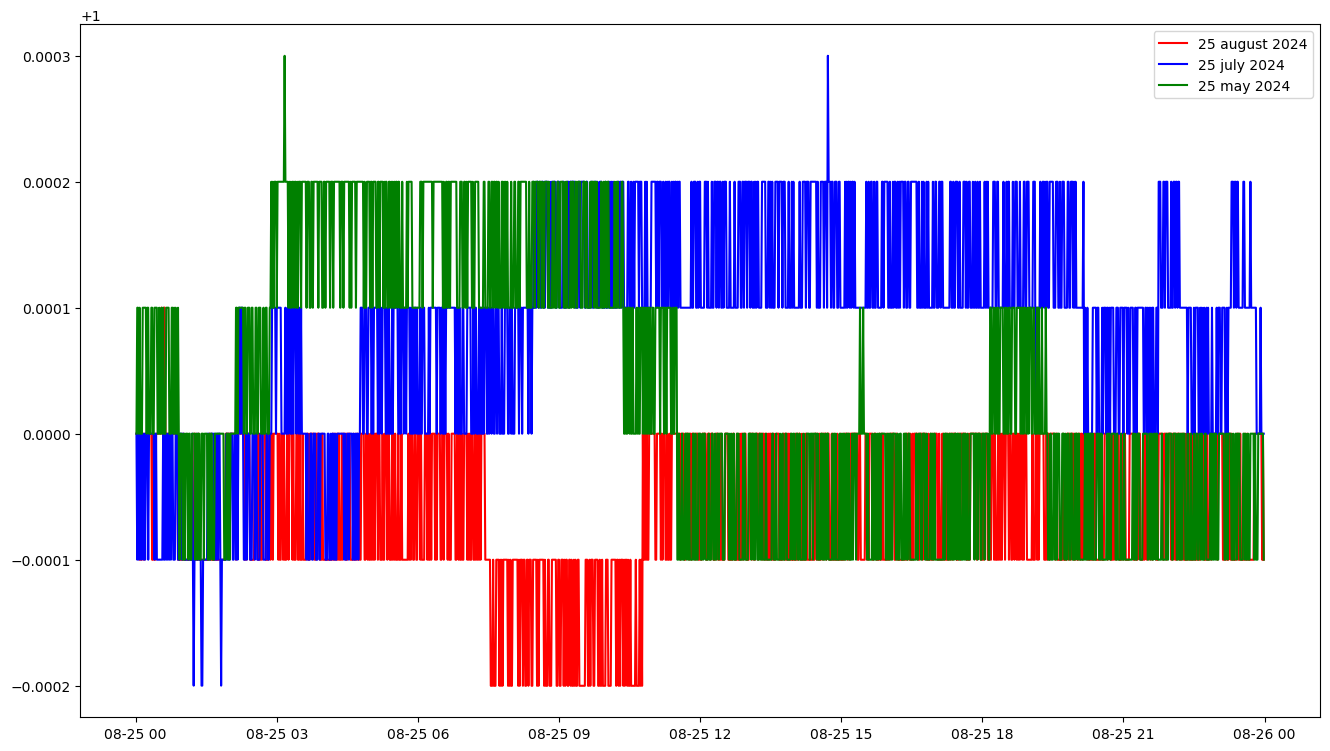

In [17]:
plt.plot(df_0.index.values, pa_0[0,:], 'r', label="25 august 2024")
plt.plot(df_0.index.values, pa_1[0,:], 'b', label="25 july 2024")
plt.plot(df_0.index.values, pa_2[0,:], 'g', label="25 may 2024")
plt.legend()
plt.show()

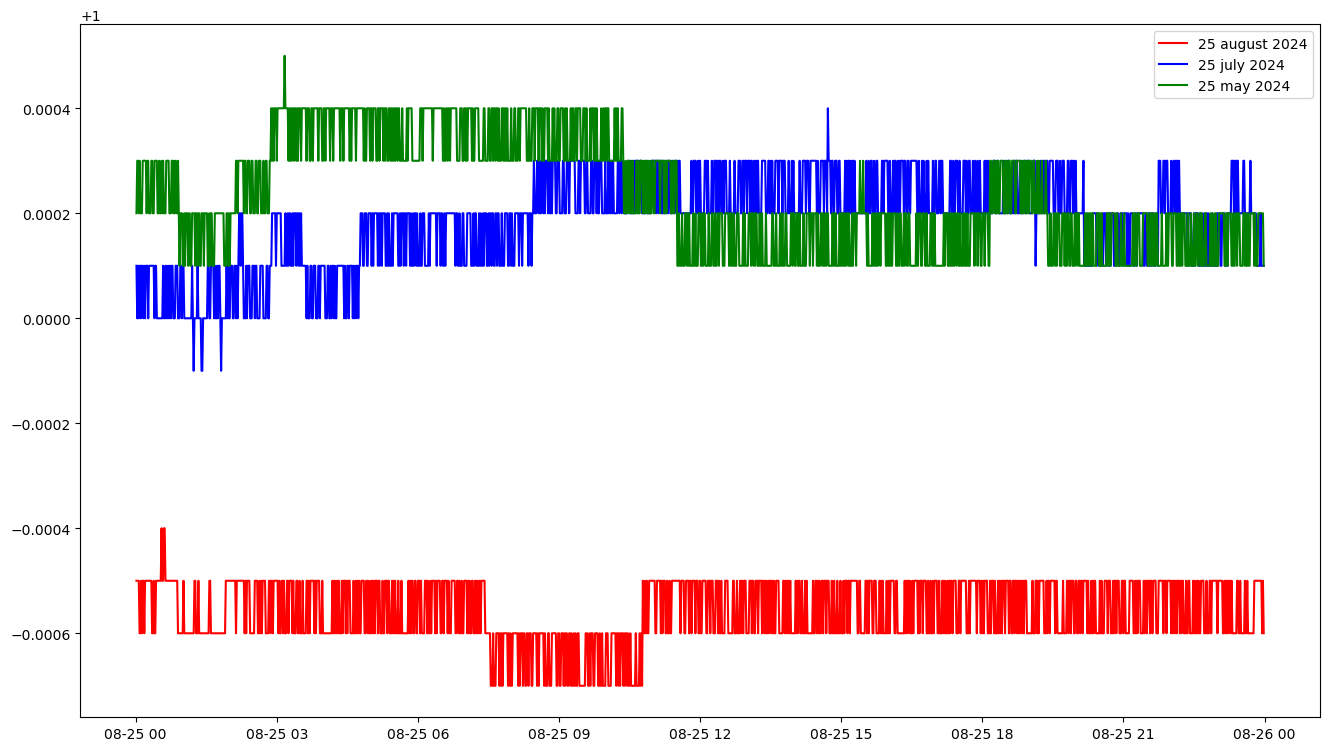

In [18]:
plt.plot(df_0.index.values, df_0['close'].values, 'r', label="25 august 2024")
plt.plot(df_0.index.values, df_1['close'].values, 'b', label="25 july 2024")
plt.plot(df_0.index.values, df_2['close'].values, 'g', label="25 may 2024")
plt.legend()
plt.show()

In [19]:
print(df_0['close'].values[0], df_0['close'].values[-1])
print(df_1['close'].values[0], df_1['close'].values[-1])
print(df_2['close'].values[0], df_2['close'].values[-1])

0.9995 0.9994
1.0001 1.0001
1.0002 1.0001


In [20]:
%%time

output_vals1 = Parallel(n_jobs=8)(
    delayed(simulation_realprice)( N, T, dt, pa_0, buy, sell, noise, eta0, eta1_vals[j], X, Y) for j in tqdm(range(len(eta1_vals)))
)

output_vals2 = Parallel(n_jobs=8)(
    delayed(simulation_realprice)( N, T, dt, pa_1, buy, sell, noise, eta0, eta1_vals[j], X, Y) for j in tqdm(range(len(eta1_vals)))
)

output_vals3 = Parallel(n_jobs=8)(
    delayed(simulation_realprice)( N, T, dt, pa_2, buy, sell, noise, eta0, eta1_vals[j], X, Y) for j in tqdm(range(len(eta1_vals)))
)


  8%|██████▋                                                                              | 8/101 [00:00<00:01, 49.74it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


100%|███████████████████████████████████████████████████████████████████████████████████| 101/101 [00:03<00:00, 29.54it/s]


CPU times: user 1.4 s, sys: 187 ms, total: 1.58 s
Wall time: 14 s


In [21]:
output_vals1 = np.array(output_vals1)
output_vals2 = np.array(output_vals2)
output_vals3 = np.array(output_vals3)

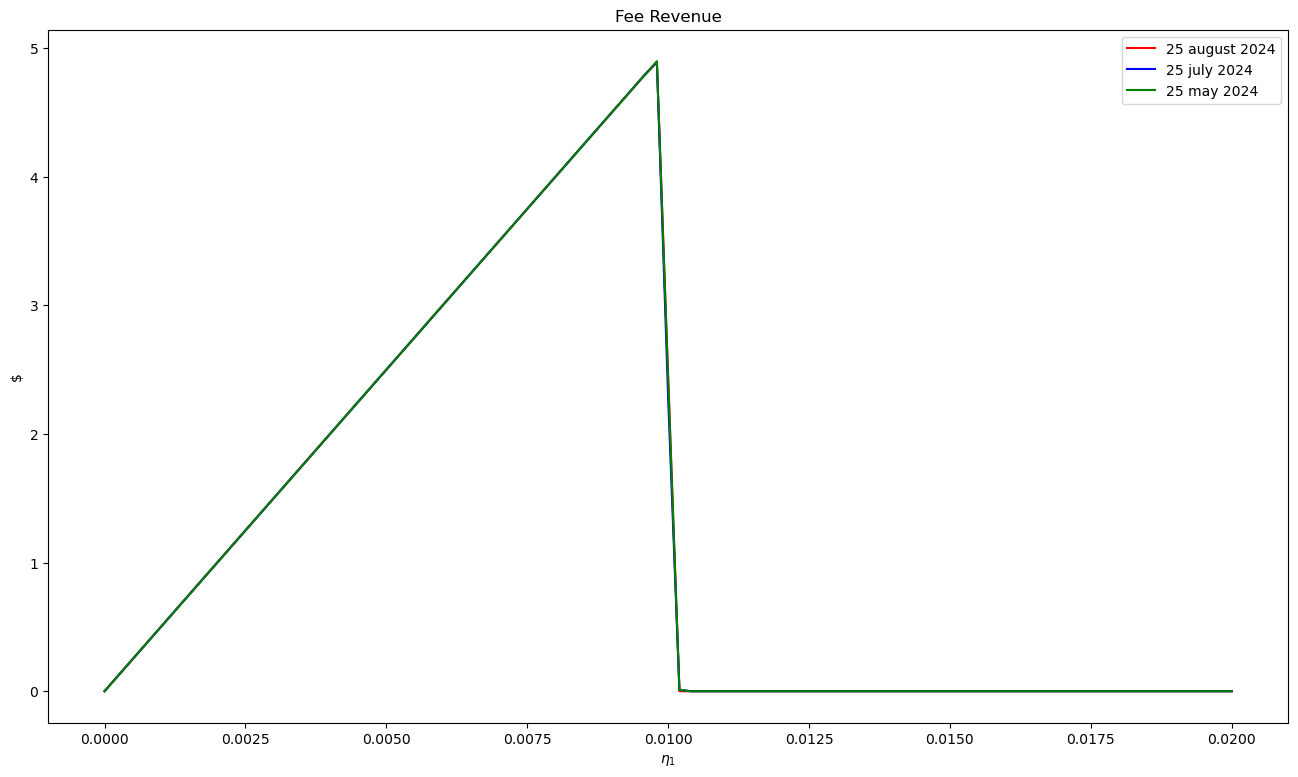

In [22]:
plt.plot(eta1_vals,output_vals1[:,0]+output_vals1[:,1]+output_vals1[:,2], color='red',label="25 august 2024")
plt.plot(eta1_vals,output_vals2[:,0]+output_vals2[:,1]+output_vals2[:,2], color='blue',label="25 july 2024")
plt.plot(eta1_vals,output_vals3[:,0]+output_vals3[:,1]+output_vals3[:,2], color='green',label="25 may 2024")
plt.title("Fee Revenue")
plt.ylabel("\$")
plt.xlabel("$\eta_1$")
plt.legend()
plt.savefig('fee_rev_eta_sigma_mr.pdf')

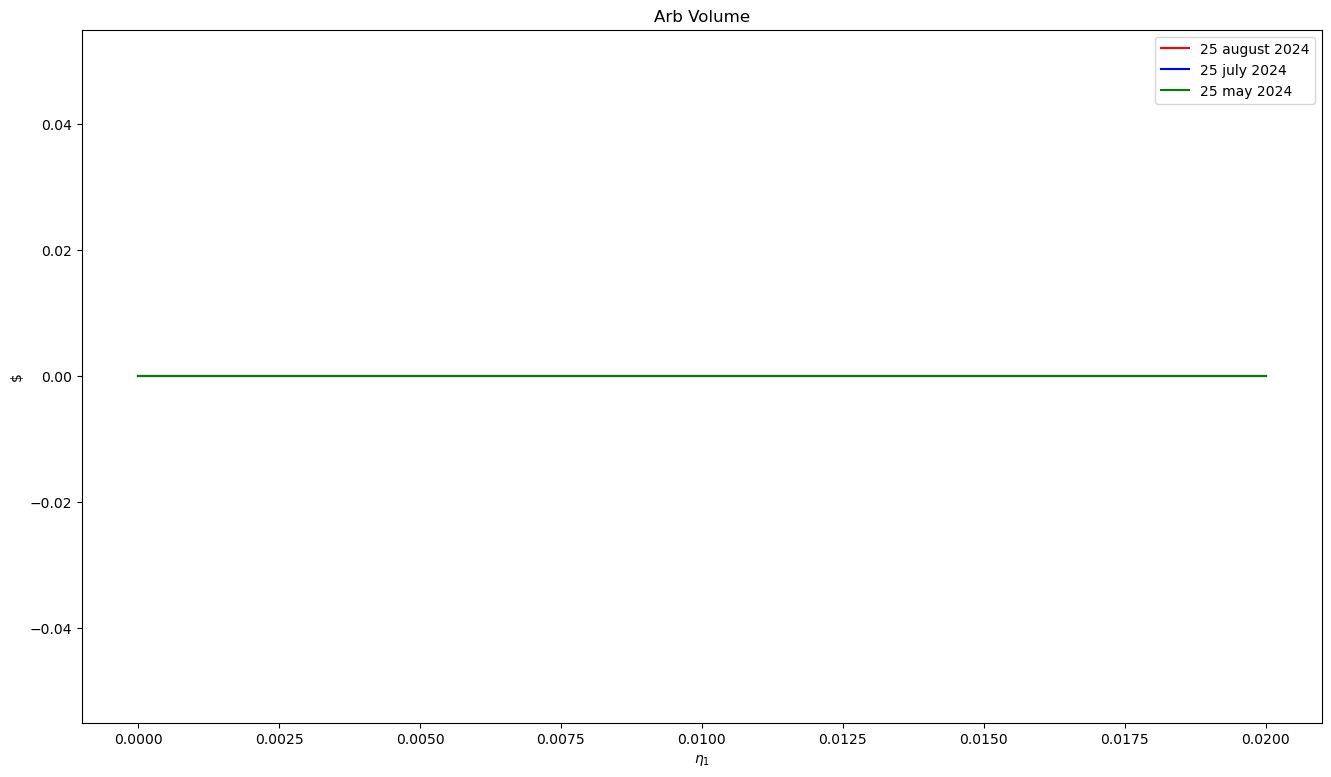

In [23]:
plt.plot(eta1_vals,output_vals1[:,6], color='red',label="25 august 2024")
plt.plot(eta1_vals,output_vals2[:,6], color='blue',label="25 july 2024")
plt.plot(eta1_vals,output_vals3[:,6], color='green',label="25 may 2024")
plt.title("Arb Volume")
plt.ylabel("\$")
plt.xlabel("$\eta_1$")
plt.legend()
plt.savefig('arb_vol_eta_sigma_mr.pdf')

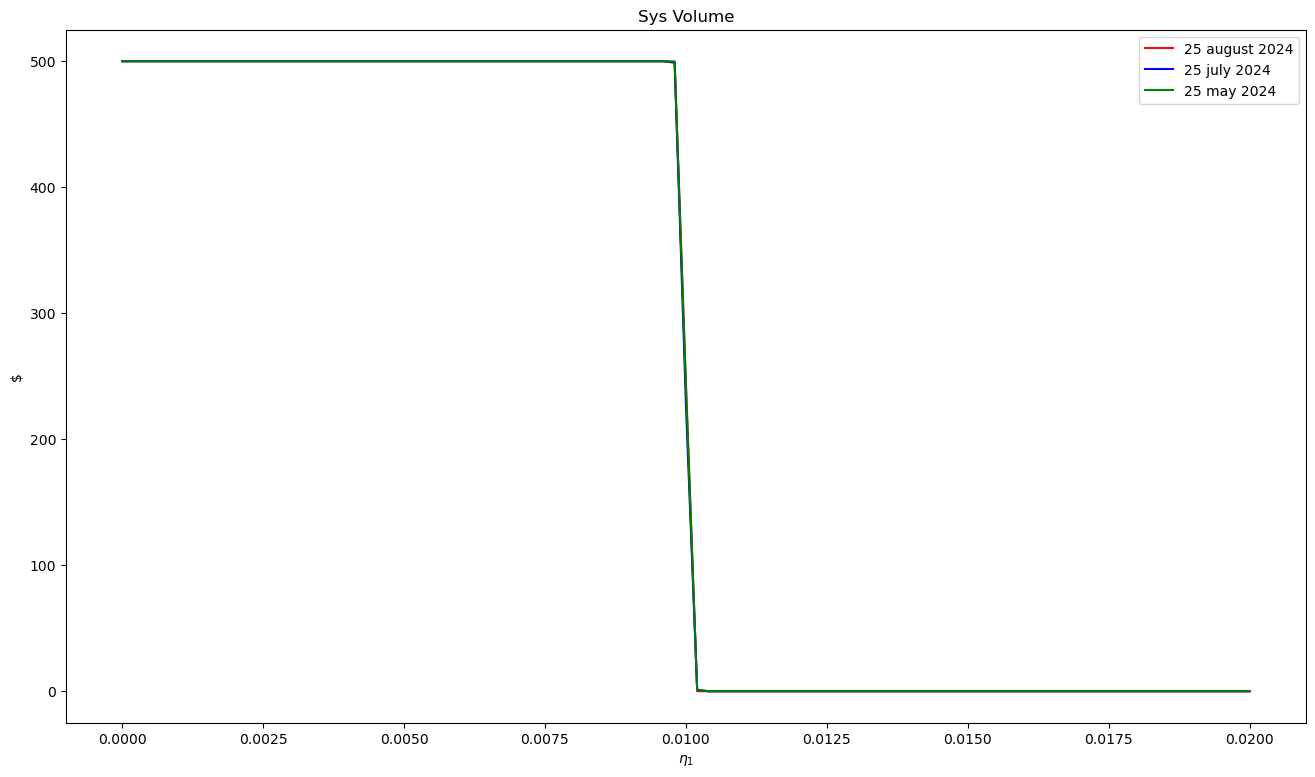

In [24]:
plt.plot(eta1_vals,output_vals1[:,4]-output_vals1[:,5], color='red',label="25 august 2024")
plt.plot(eta1_vals,output_vals2[:,4]-output_vals2[:,5], color='blue',label="25 july 2024")
plt.plot(eta1_vals,output_vals3[:,4]-output_vals3[:,5], color='green',label="25 may 2024")
plt.title("Sys Volume")
plt.ylabel("\$")
plt.xlabel("$\eta_1$")
plt.legend()
plt.savefig('arb_vol_eta_sigma_mr.pdf')

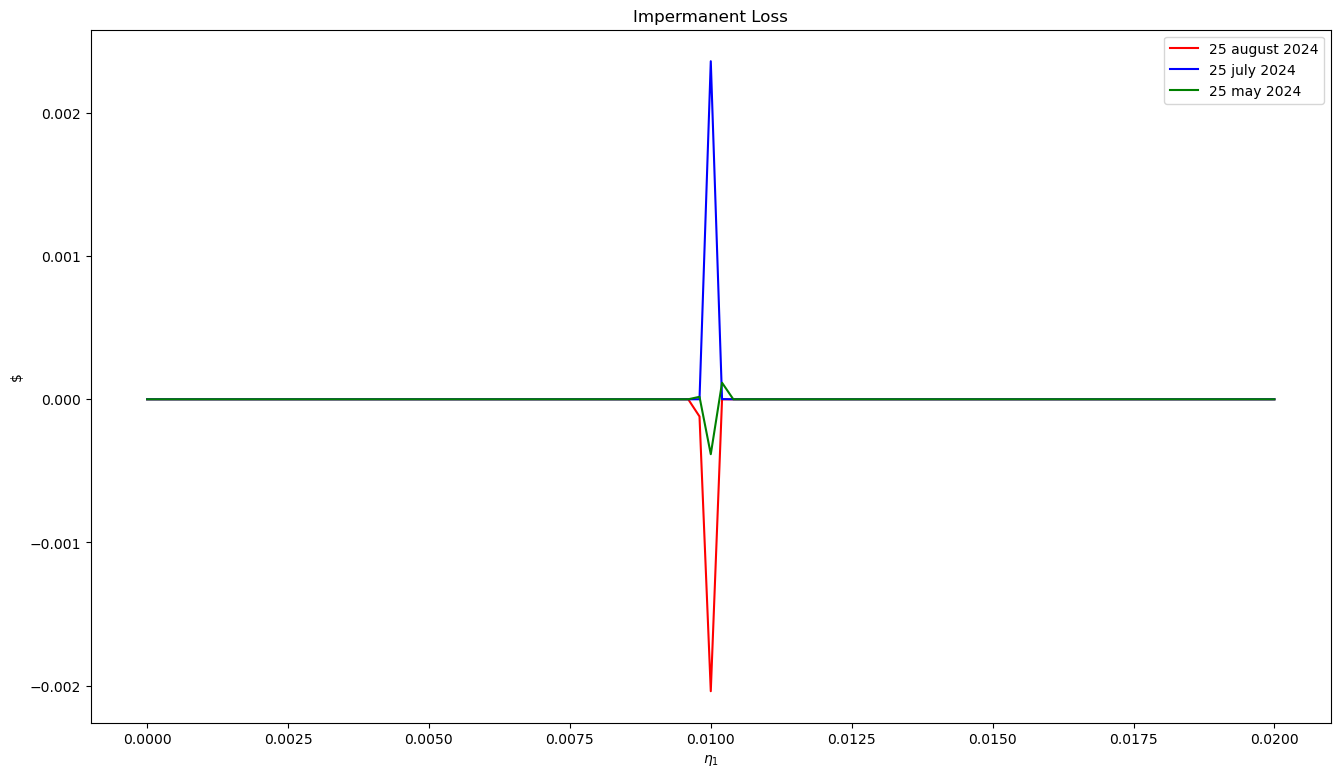

In [25]:
plt.plot(eta1_vals,output_vals1[:,3], color='red',label="25 august 2024")
plt.plot(eta1_vals,output_vals2[:,3], color='blue',label="25 july 2024")
plt.plot(eta1_vals,output_vals3[:,3], color='green',label="25 may 2024")
plt.title("Impermanent Loss")
plt.ylabel("\$")
plt.xlabel("$\eta_1$")
plt.legend()
plt.savefig('imp_loss_eta_sigma_mr.pdf')

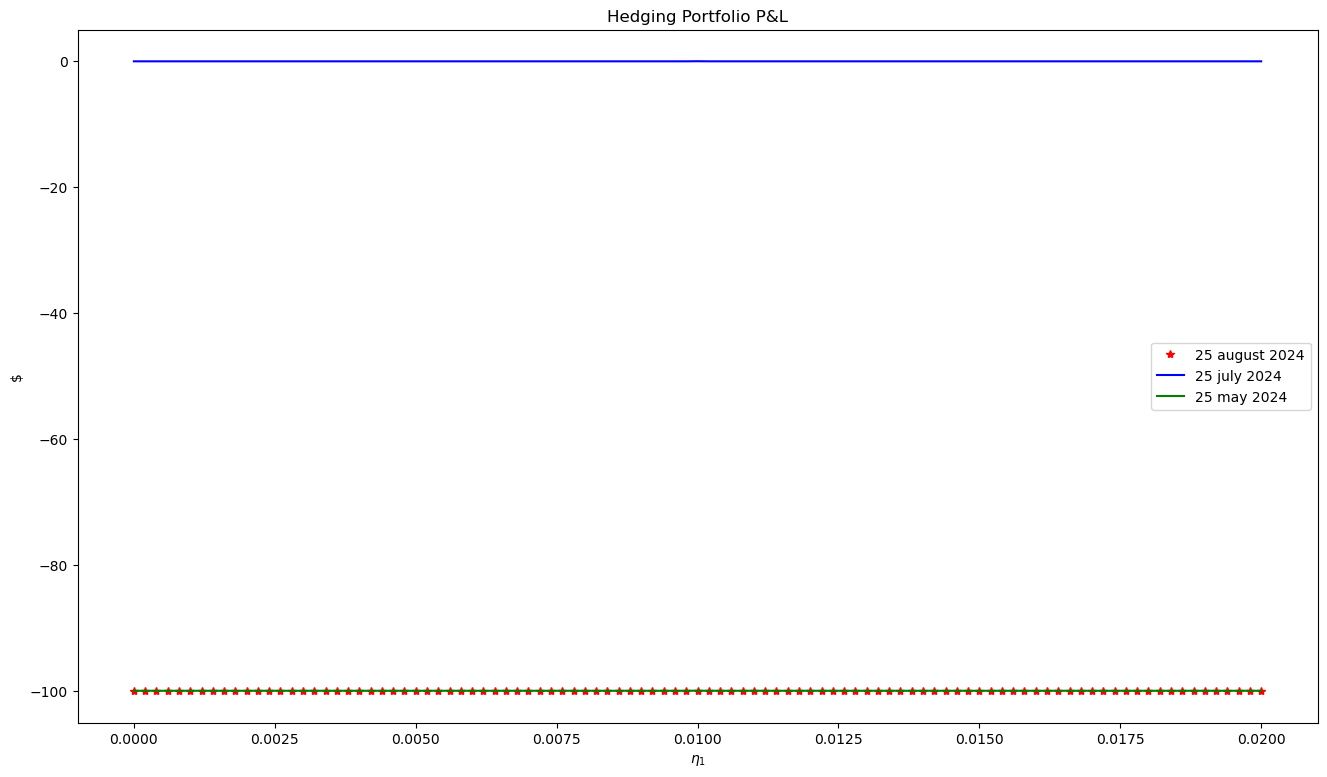

In [26]:
plt.plot(eta1_vals,output_vals1[:,15]-output_vals1[:,13], '*r',label="25 august 2024")
plt.plot(eta1_vals,output_vals2[:,15]-output_vals2[:,13], color='blue',label="25 july 2024")
plt.plot(eta1_vals,output_vals3[:,15]-output_vals3[:,13], color='green',label="25 may 2024")
plt.title("Hedging Portfolio P&L")
plt.ylabel("\$")
plt.xlabel("$\eta_1$")
plt.legend()
plt.savefig('tracking_eta_sigma_mr.pdf')

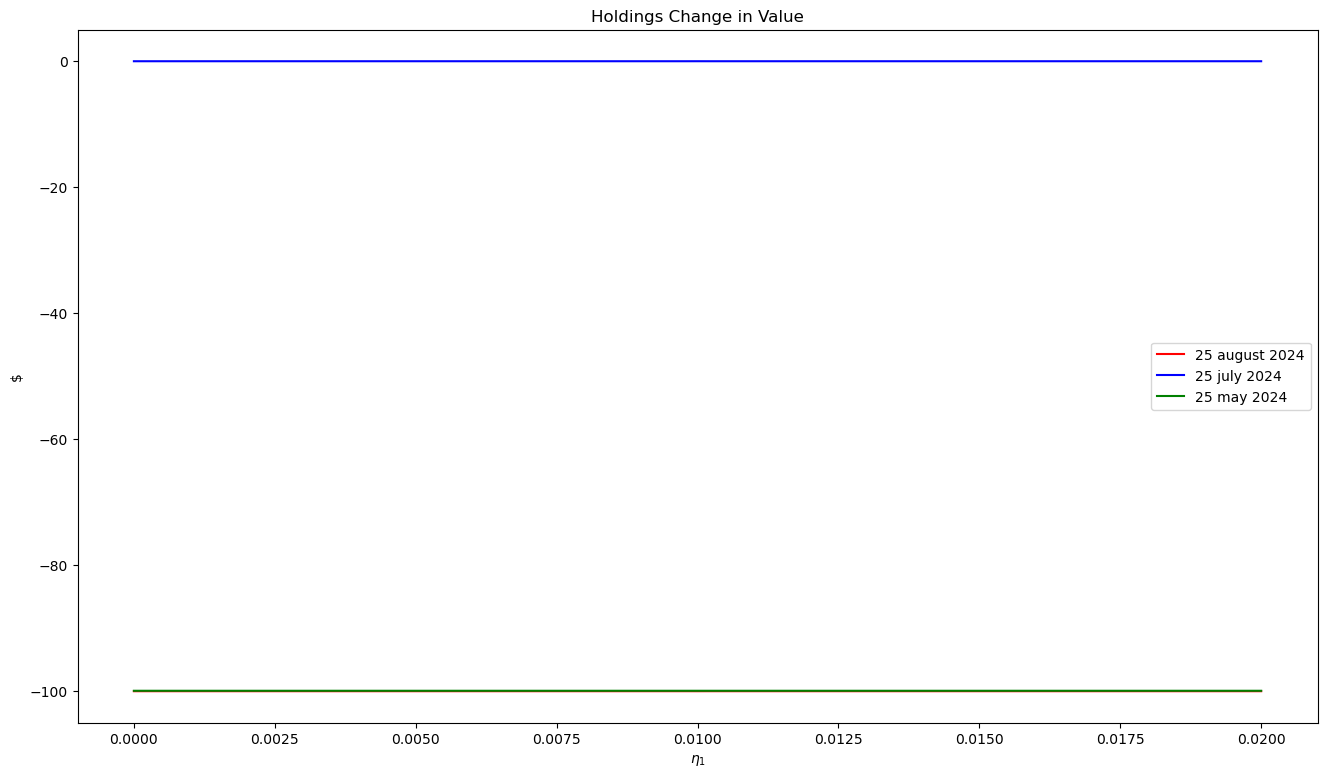

In [27]:
plt.plot(eta1_vals,output_vals1[:,12]-output_vals1[:,13], color='red',label="25 august 2024")
plt.plot(eta1_vals,output_vals2[:,12]-output_vals2[:,13], color='blue',label="25 july 2024")
plt.plot(eta1_vals,output_vals3[:,12]-output_vals3[:,13], color='green',label="25 may 2024")
plt.title("Holdings Change in Value")
plt.ylabel("\$")
plt.xlabel("$\eta_1$")
plt.legend()
plt.savefig('holdings_change_eta_sigma_mr.pdf')

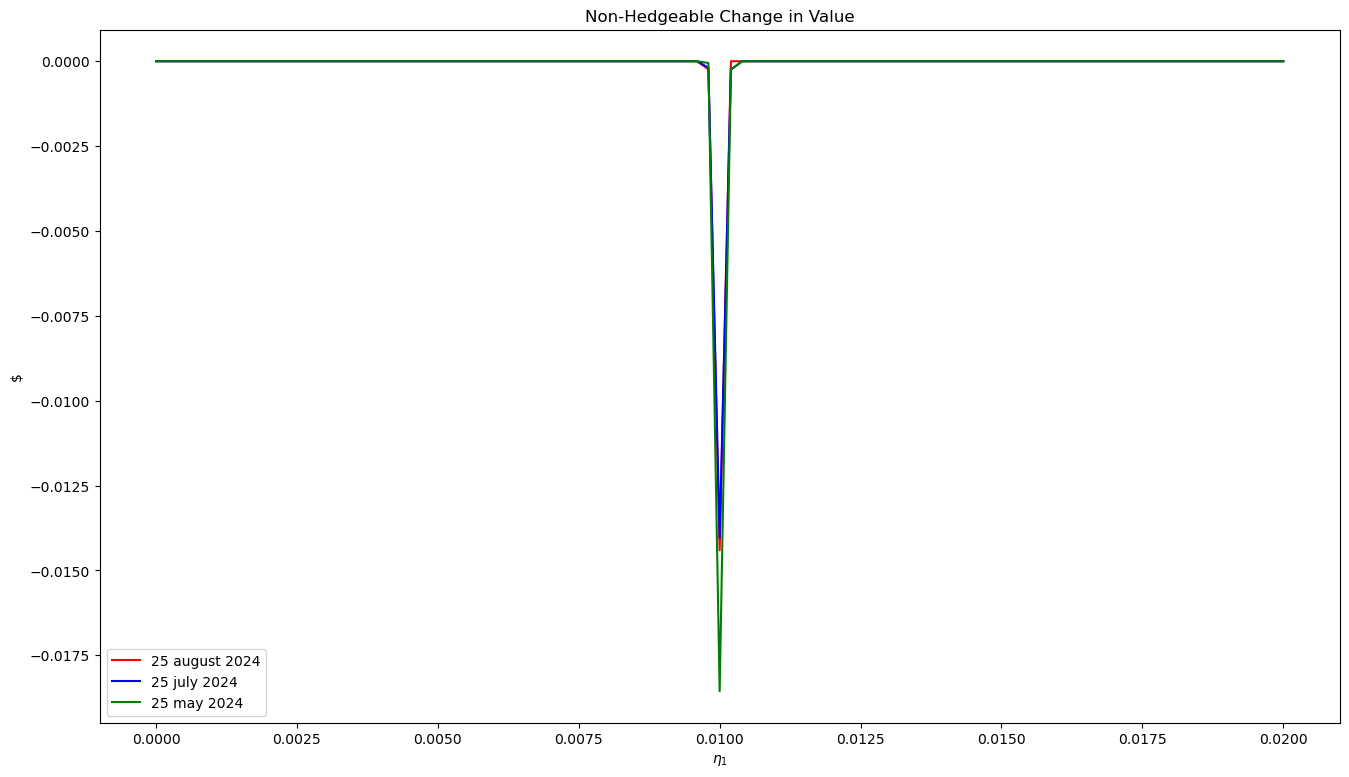

In [28]:
plt.plot(eta1_vals,output_vals1[:,12]-output_vals1[:,13]-(output_vals1[:,15]-output_vals1[:,13]), color='red',label="25 august 2024")
plt.plot(eta1_vals,output_vals2[:,12]-output_vals2[:,13]-(output_vals2[:,15]-output_vals2[:,13]), color='blue',label="25 july 2024")
plt.plot(eta1_vals,output_vals3[:,12]-output_vals3[:,13]-(output_vals3[:,15]-output_vals3[:,13]), color='green',label="25 may 2024")
plt.title("Non-Hedgeable Change in Value")
plt.ylabel("\$")
plt.xlabel("$\eta_1$")
plt.legend()
plt.savefig('nonhedge_change_eta_sigma_mr.pdf')

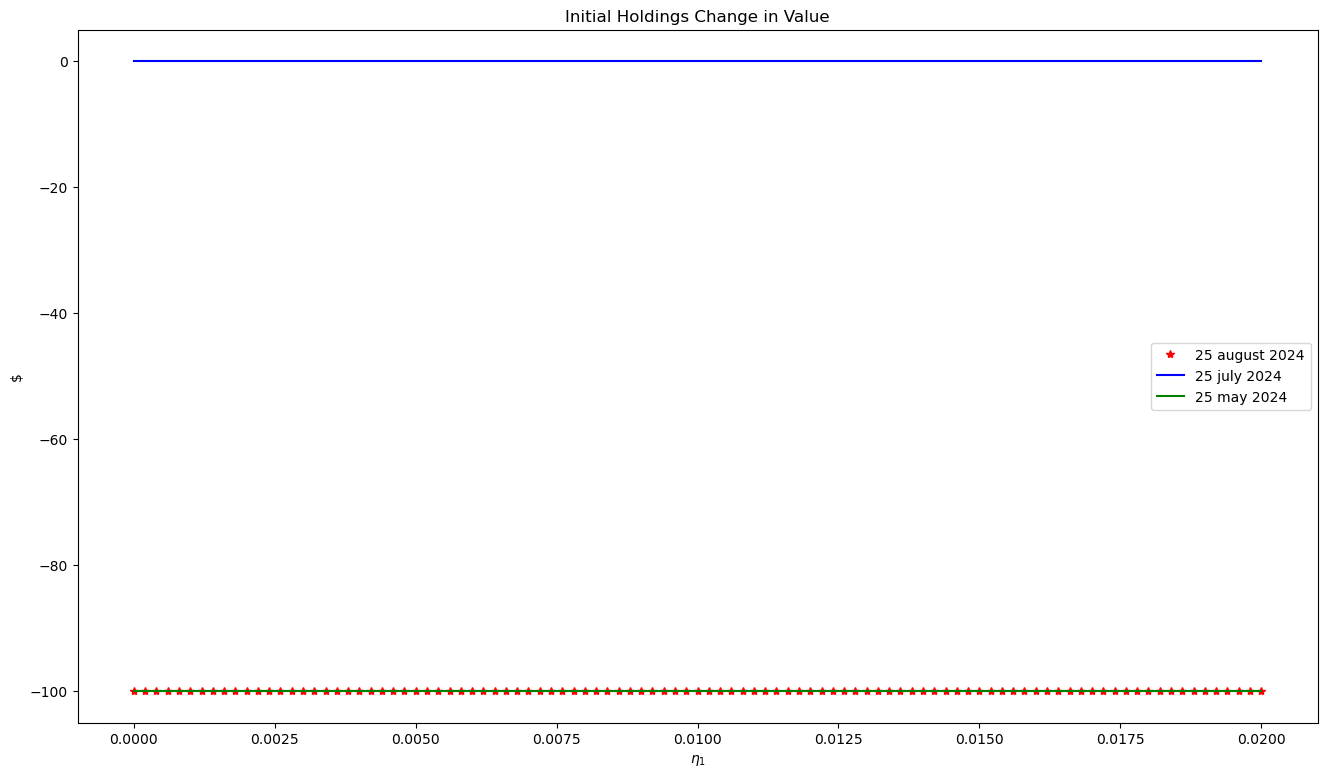

In [29]:
plt.plot(eta1_vals,output_vals1[:,14]-output_vals1[:,13], '*r',label="25 august 2024")
plt.plot(eta1_vals,output_vals2[:,14]-output_vals2[:,13], color='blue',label="25 july 2024")
plt.plot(eta1_vals,output_vals3[:,14]-output_vals3[:,13], color='green',label="25 may 2024")
plt.title("Initial Holdings Change in Value")
plt.ylabel("\$")
plt.xlabel("$\eta_1$")
plt.legend()
plt.savefig('init_change_eta_sigma_mr.pdf')

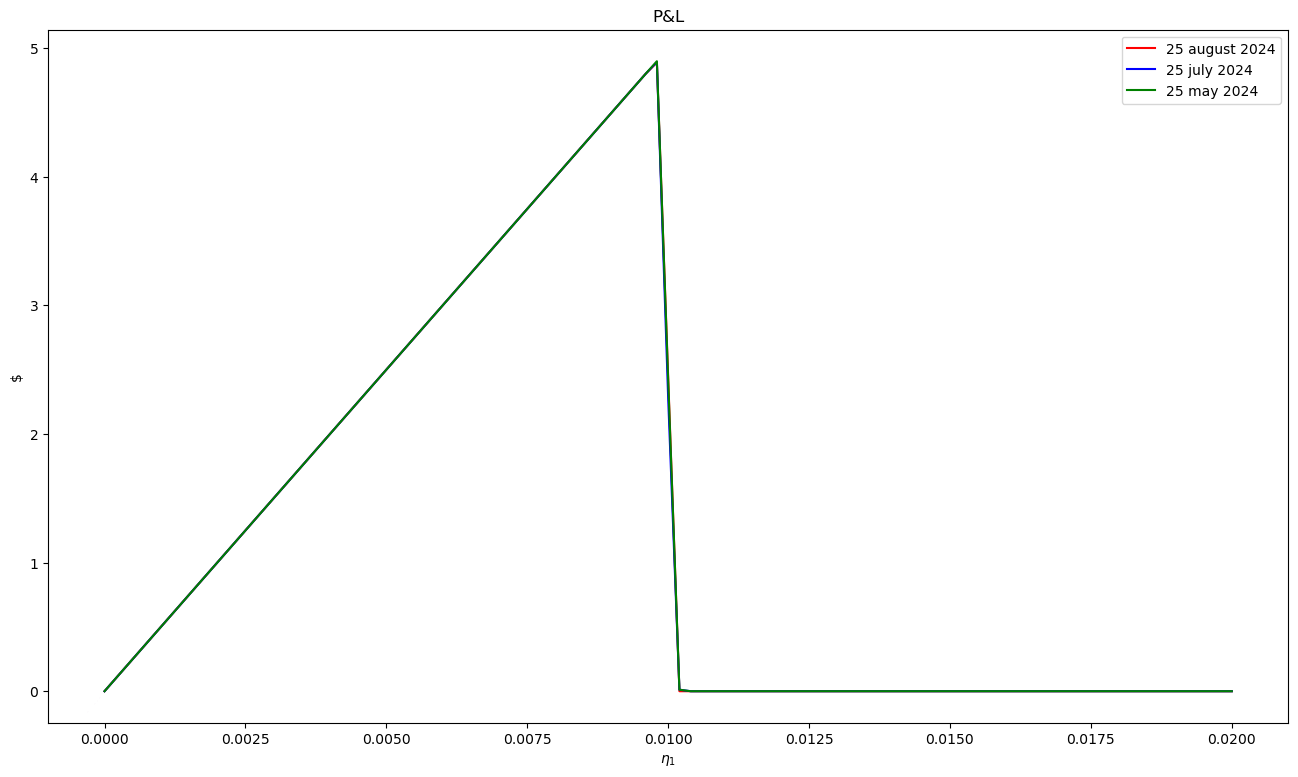

In [30]:
plt.plot(eta1_vals,output_vals1[:,0]+output_vals1[:,1]+output_vals1[:,2]+output_vals1[:,3], color='red',label="25 august 2024")
plt.plot(eta1_vals,output_vals2[:,0]+output_vals2[:,1]+output_vals2[:,2]+output_vals2[:,3], color='blue',label="25 july 2024")
plt.plot(eta1_vals,output_vals3[:,0]+output_vals3[:,1]+output_vals3[:,2]+output_vals3[:,3], color='green',label="25 may 2024")
plt.title("P&L")
plt.ylabel("\$")
plt.xlabel("$\eta_1$")
plt.legend()
plt.savefig('pnl_eta_sigma_mr.pdf')

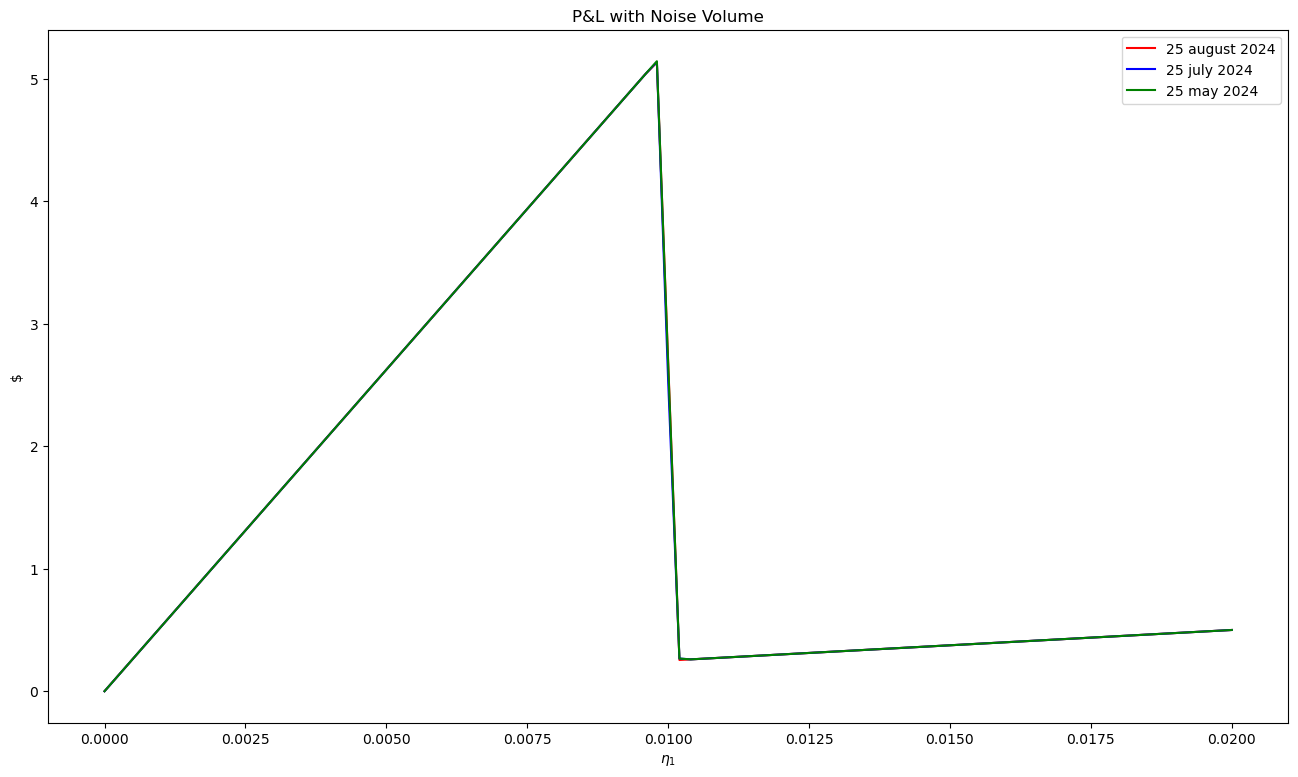

In [31]:
plt.plot(eta1_vals,output_vals1[:,0]+output_vals1[:,1]+output_vals1[:,2]+output_vals1[:,3]+output_vals1[:,16], color='red',label="25 august 2024")
plt.plot(eta1_vals,output_vals2[:,0]+output_vals2[:,1]+output_vals2[:,2]+output_vals2[:,3]+output_vals2[:,16], color='blue',label="25 july 2024")
plt.plot(eta1_vals,output_vals3[:,0]+output_vals3[:,1]+output_vals3[:,2]+output_vals3[:,3]+output_vals3[:,16], color='green',label="25 may 2024")
plt.title("P&L with Noise Volume")
plt.ylabel("\$")
plt.xlabel("$\eta_1$")
plt.legend()
plt.savefig('pnl_eta_sigma_noise_mr.pdf')

In [46]:
%%time
S0 = pa_0[0,0]
S1 = pa_1[0,0]
S2 = pa_2[0,0]

Ks = np.array([250+i*100 for i in range(1,51)])


Xs0 = np.array([np.sqrt(S0)*Ks[i] for i in range(len(Ks))])
Ys0 = np.array([Ks[i]/np.sqrt(S0) for i in range(len(Ks))])
output_vals1 = Parallel(n_jobs=6)(
    delayed(simulation_realprice)(N, T, dt, pa_0, buy, sell, noise, eta0, eta1, Xs0[j], Ys0[j]) for j in tqdm(range(len(Ys0)))
)

Xs1 = np.array([np.sqrt(S1)*Ks[i] for i in range(len(Ks))])
Ys1 = np.array([Ks[i]/np.sqrt(S1) for i in range(len(Ks))])
output_vals2 = Parallel(n_jobs=6)(
    delayed(simulation_realprice)(N, T, dt, pa_1, buy, sell, noise, eta0, eta1, Xs1[j], Ys1[j]) for j in tqdm(range(len(Ys1)))
)

Xs2 = np.array([np.sqrt(S2)*Ks[i] for i in range(len(Ks))])
Ys2 = np.array([Ks[i]/np.sqrt(S2) for i in range(len(Ks))])
output_vals3 = Parallel(n_jobs=6)(
    delayed(simulation_realprice)(N, T, dt, pa_2, buy, sell, noise, eta0, eta1, Xs2[j], Ys2[j]) for j in tqdm(range(len(Ys2)))
)

100%|█████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.32it/s]


CPU times: user 605 ms, sys: 45.1 ms, total: 651 ms
Wall time: 7.37 s


In [47]:
print(Ks)
print(Xs0)
print(Ys0)

[ 350  450  550  650  750  850  950 1050 1150 1250 1350 1450 1550 1650
 1750 1850 1950 2050 2150 2250 2350 2450 2550 2650 2750 2850 2950 3050
 3150 3250 3350 3450 3550 3650 3750 3850 3950 4050 4150 4250 4350 4450
 4550 4650 4750 4850 4950 5050 5150 5250]
[ 349.91248906  449.88748593  549.86248281  649.83747968  749.81247656
  849.78747343  949.76247031 1049.73746718 1149.71246405 1249.68746093
 1349.6624578  1449.63745468 1549.61245155 1649.58744842 1749.5624453
 1849.53744217 1949.51243905 2049.48743592 2149.4624328  2249.43742967
 2349.41242654 2449.38742342 2549.36242029 2649.33741717 2749.31241404
 2849.28741092 2949.26240779 3049.23740466 3149.21240154 3249.18739841
 3349.16239529 3449.13739216 3549.11238903 3649.08738591 3749.06238278
 3849.03737966 3949.01237653 4048.98737341 4148.96237028 4248.93736715
 4348.91236403 4448.8873609  4548.86235778 4648.83735465 4748.81235153
 4848.7873484  4948.76234527 5048.73734215 5148.71233902 5248.6873359 ]
[ 350.08753283  450.11254221  550.1

In [48]:
output_vals1 = np.array(output_vals1)
output_vals2 = np.array(output_vals2)
output_vals3 = np.array(output_vals3)

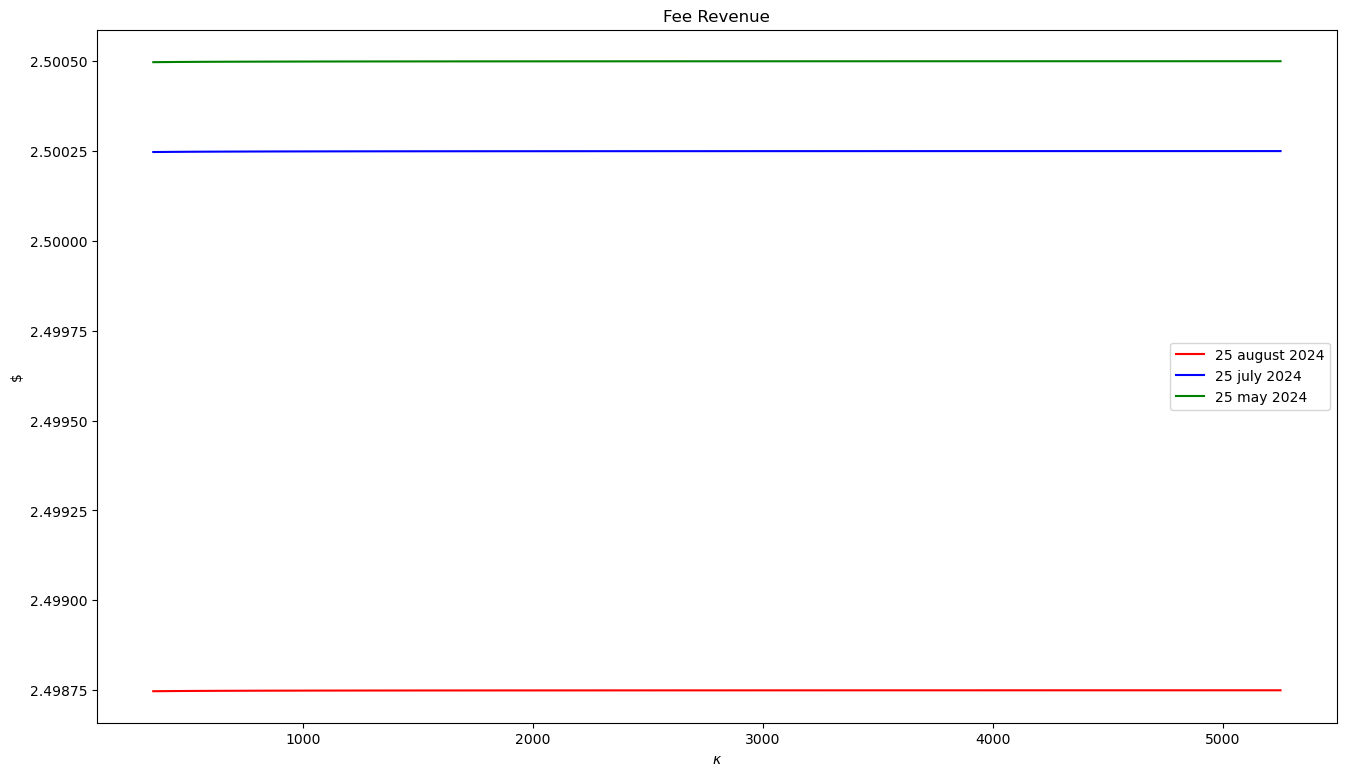

In [49]:
plt.plot(Ks,output_vals1[:,0]+output_vals1[:,1]+output_vals1[:,2], color='red',label="25 august 2024")
plt.plot(Ks,output_vals2[:,0]+output_vals2[:,1]+output_vals2[:,2], color='blue',label="25 july 2024")
plt.plot(Ks,output_vals3[:,0]+output_vals3[:,1]+output_vals3[:,2], color='green',label="25 may 2024")
plt.title("Fee Revenue")
plt.ylabel("\$")
plt.xlabel("$\kappa$")
plt.legend()
plt.savefig('fee_rev_liquidity_mr.pdf')

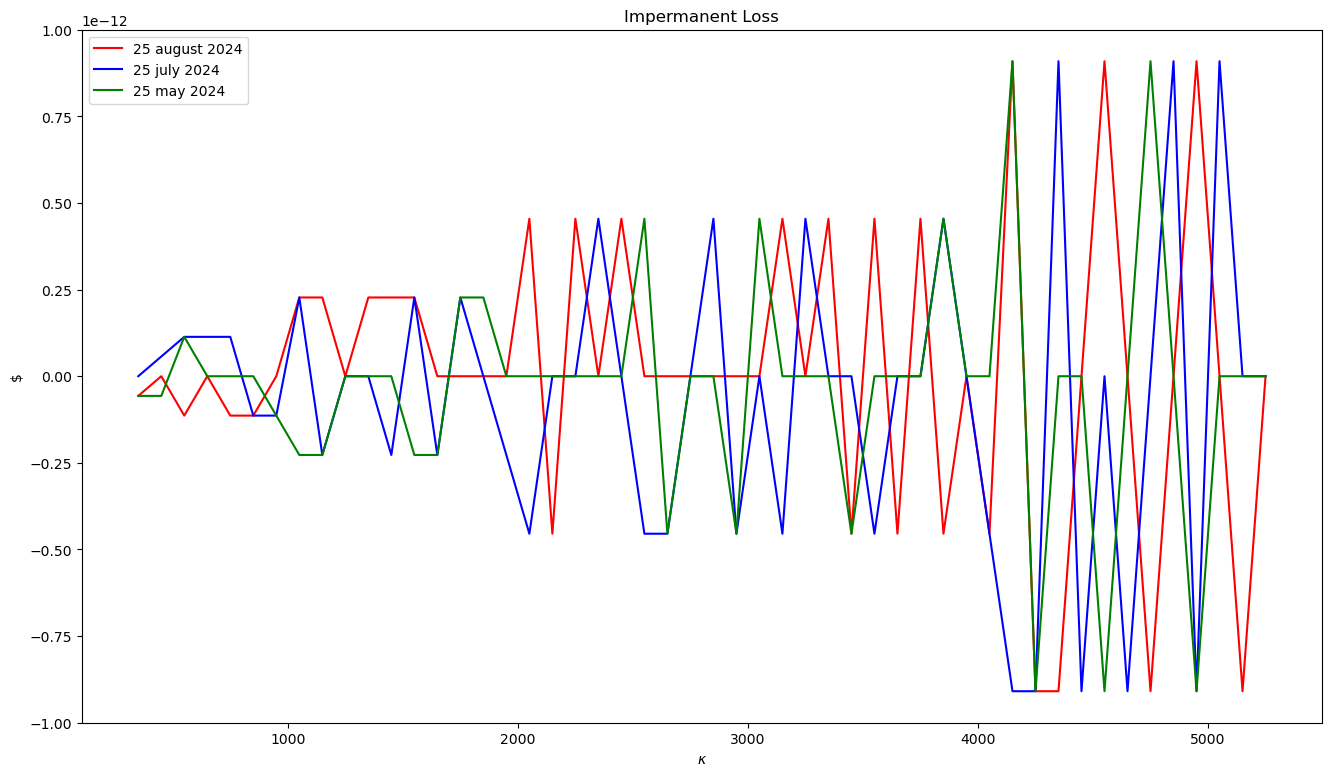

In [50]:
plt.plot(Ks,output_vals1[:,3], color='red',label="25 august 2024")
plt.plot(Ks,output_vals2[:,3], color='blue',label="25 july 2024")
plt.plot(Ks,output_vals3[:,3], color='green',label="25 may 2024")
plt.title("Impermanent Loss")
plt.ylabel("\$")
plt.xlabel("$\kappa$")
plt.legend()
plt.savefig('imp_loss_liquidity_mr.pdf')

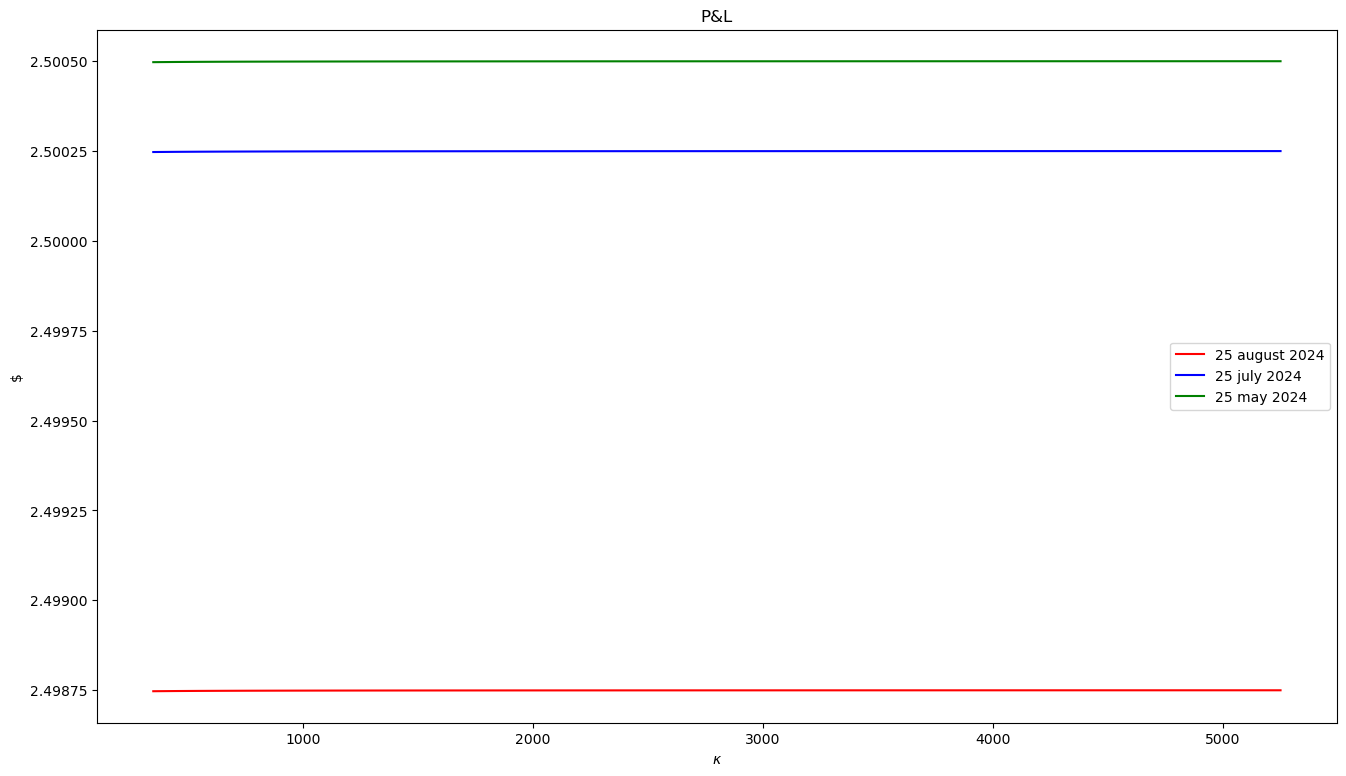

In [51]:
plt.plot(Ks,output_vals1[:,0]+output_vals1[:,1]+output_vals1[:,2]+output_vals1[:,3], color='red',label="25 august 2024")
plt.plot(Ks,output_vals2[:,0]+output_vals2[:,1]+output_vals2[:,2]+output_vals2[:,3], color='blue',label="25 july 2024")
plt.plot(Ks,output_vals3[:,0]+output_vals3[:,1]+output_vals3[:,2]+output_vals3[:,3], color='green',label="25 may 2024")
plt.title("P&L")
plt.ylabel("\$")
plt.xlabel("$\kappa$")
plt.legend()
plt.savefig('pnl_liquidity_mr.pdf')

In [52]:
%%time


buys = np.array([100*i*dt for i in range(0,101)])
sells = np.array([-100*i*dt for i in range(0,101)])

output_vals1 = Parallel(n_jobs=6)(
    delayed(simulation_realprice)(N, T, dt, pa_0, buys[j], sells[j], noise, eta0, eta1, X, Y) for j in tqdm(range(len(buys)))
)
output_vals2 = Parallel(n_jobs=6)(
    delayed(simulation_realprice)(N, T, dt, pa_1, buys[j], sells[j], noise, eta0, eta1, X, Y) for j in tqdm(range(len(buys)))
)
output_vals3 = Parallel(n_jobs=6)(
    delayed(simulation_realprice)(N, T, dt, pa_2, buys[j], sells[j], noise, eta0, eta1, X, Y) for j in tqdm(range(len(buys)))
)

100%|███████████████████████████████████████████████████████████████████████████████████| 101/101 [00:03<00:00, 25.62it/s]


CPU times: user 1.38 s, sys: 88.6 ms, total: 1.47 s
Wall time: 13.9 s


In [53]:
output_vals1 = np.array(output_vals1)
output_vals2 = np.array(output_vals2)
output_vals3 = np.array(output_vals3)

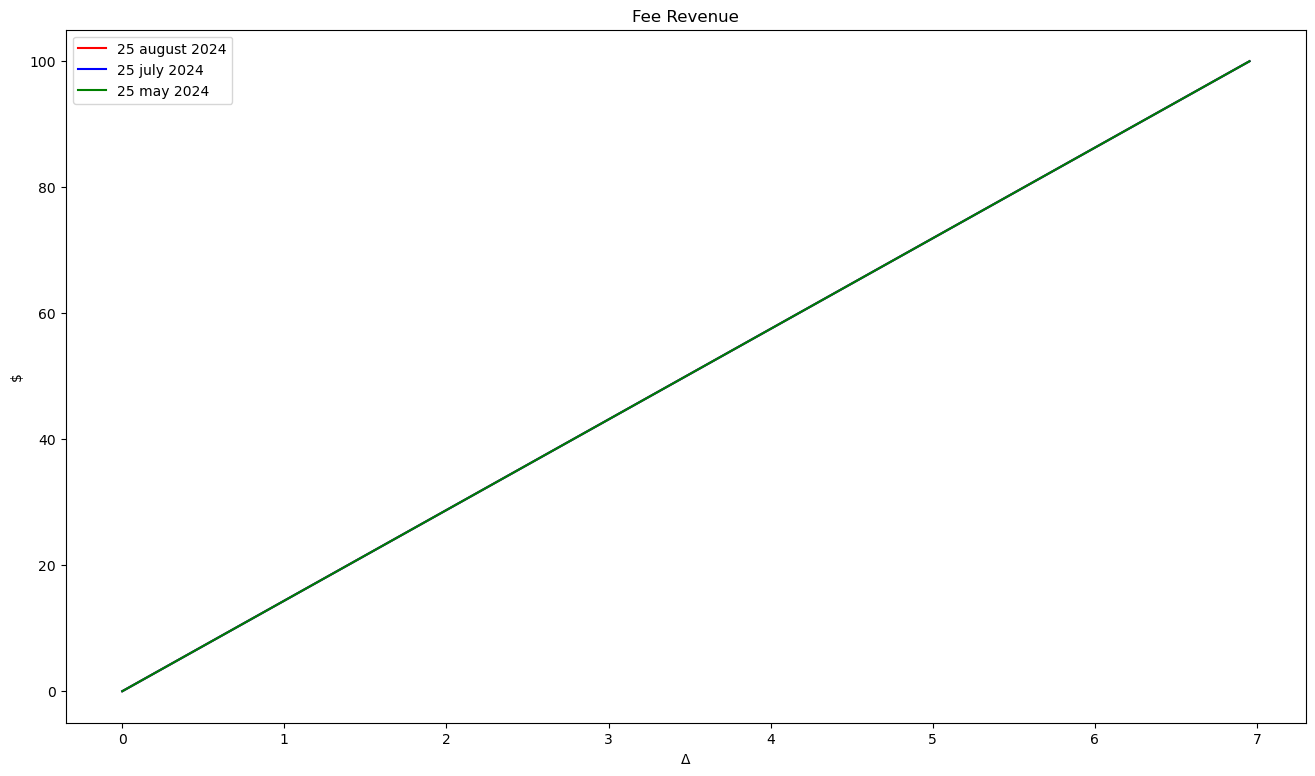

In [54]:
plt.plot(buys,output_vals1[:,0]+output_vals1[:,1]+output_vals1[:,2], color='red',label="25 august 2024")
plt.plot(buys,output_vals2[:,0]+output_vals2[:,1]+output_vals2[:,2], color='blue',label="25 july 2024")
plt.plot(buys,output_vals3[:,0]+output_vals3[:,1]+output_vals3[:,2], color='green',label="25 may 2024")
plt.title("Fee Revenue")
plt.ylabel("\$")
plt.xlabel("$\Delta$")
plt.legend()
plt.savefig('fee_rev_sys_vol_mr.pdf')

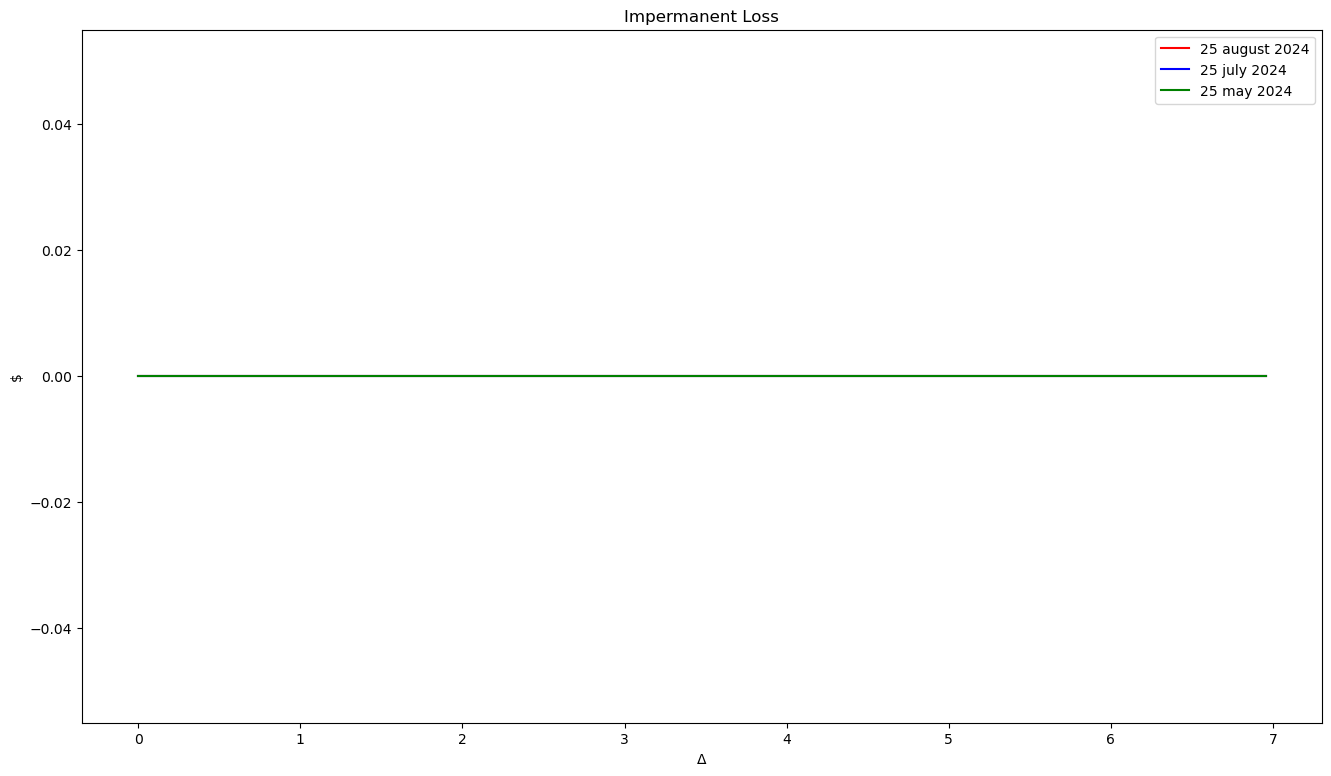

In [55]:
plt.plot(buys,output_vals1[:,3], color='red',label="25 august 2024")
plt.plot(buys,output_vals2[:,3], color='blue',label="25 july 2024")
plt.plot(buys,output_vals3[:,3], color='green',label="25 may 2024")
plt.title("Impermanent Loss")
plt.ylabel("\$")
plt.xlabel("$\Delta$")
plt.legend()
plt.savefig('imp_loss_sys_vol_mr.pdf')

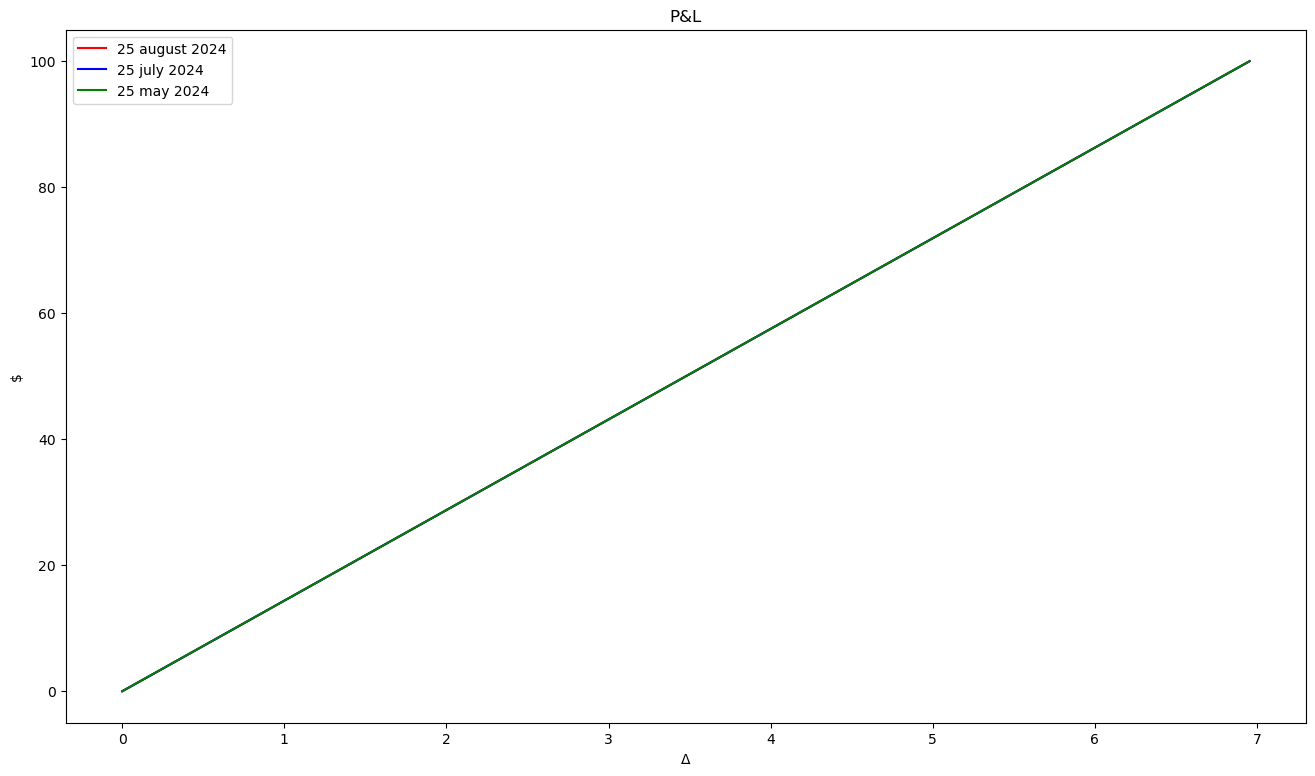

In [56]:
plt.plot(buys,output_vals1[:,0]+output_vals1[:,1]+output_vals1[:,2]+output_vals1[:,3], color='red',label="25 august 2024")
plt.plot(buys,output_vals2[:,0]+output_vals2[:,1]+output_vals2[:,2]+output_vals2[:,3], color='blue',label="25 july 2024")
plt.plot(buys,output_vals3[:,0]+output_vals3[:,1]+output_vals3[:,2]+output_vals3[:,3], color='green',label="25 may 2024")
plt.title("P&L")
plt.ylabel("\$")
plt.xlabel("$\Delta$")
plt.legend()
plt.savefig('pnl_sys_vol_mr.pdf')

In [57]:
%%time


eta1 = 0.01

buys = np.array([100*i*dt for i in range(0,101)])
sells = np.array([-100*i*dt for i in range(0,101)])

output_vals1 = Parallel(n_jobs=6)(
    delayed(simulation_realprice)(N, T, dt, pa_0, buys[j], sells[j], noise, eta0, eta1, X, Y) for j in tqdm(range(len(buys)))
)
output_vals2 = Parallel(n_jobs=6)(
    delayed(simulation_realprice)(N, T, dt, pa_1, buys[j], sells[j], noise, eta0, eta1, X, Y) for j in tqdm(range(len(buys)))
)
output_vals3 = Parallel(n_jobs=6)(
    delayed(simulation_realprice)(N, T, dt, pa_2, buys[j], sells[j], noise, eta0, eta1, X, Y) for j in tqdm(range(len(buys)))
)

100%|███████████████████████████████████████████████████████████████████████████████████| 101/101 [00:04<00:00, 25.25it/s]


CPU times: user 1.34 s, sys: 90.3 ms, total: 1.43 s
Wall time: 13.8 s


In [58]:
output_vals1 = np.array(output_vals1)
output_vals2 = np.array(output_vals2)
output_vals3 = np.array(output_vals3)

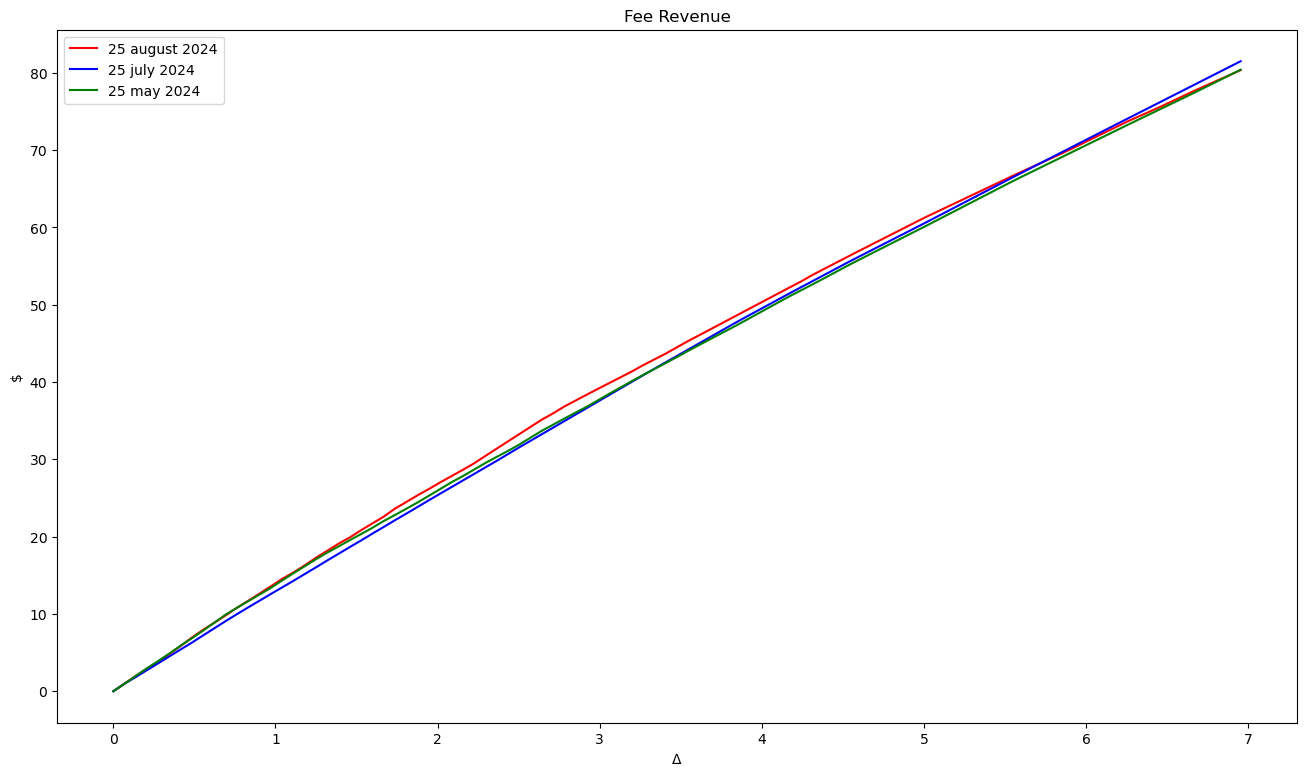

In [59]:
plt.plot(buys,output_vals1[:,0]+output_vals1[:,1]+output_vals1[:,2], color='red',label="25 august 2024")
plt.plot(buys,output_vals2[:,0]+output_vals2[:,1]+output_vals2[:,2], color='blue',label="25 july 2024")
plt.plot(buys,output_vals3[:,0]+output_vals3[:,1]+output_vals3[:,2], color='green',label="25 may 2024")
plt.title("Fee Revenue")
plt.ylabel("\$")
plt.xlabel("$\Delta$")
plt.legend()
plt.savefig('fee_rev_sys_vol_low_cost_mr.pdf')

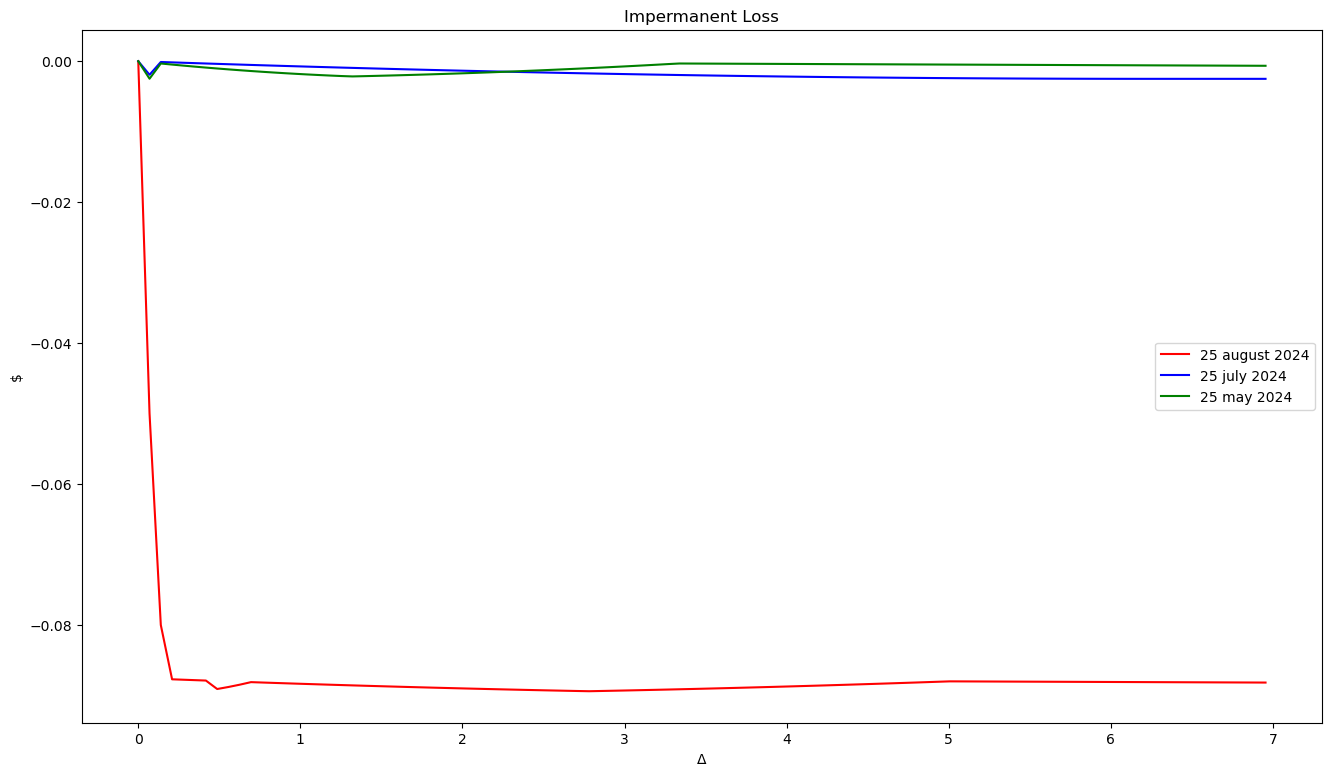

In [60]:
plt.plot(buys,output_vals1[:,3], color='red',label="25 august 2024")
plt.plot(buys,output_vals2[:,3], color='blue',label="25 july 2024")
plt.plot(buys,output_vals3[:,3], color='green',label="25 may 2024")
plt.title("Impermanent Loss")
plt.ylabel("\$")
plt.xlabel("$\Delta$")
plt.legend()
plt.savefig('imp_loss_sys_vol_low_cost_mr.pdf')

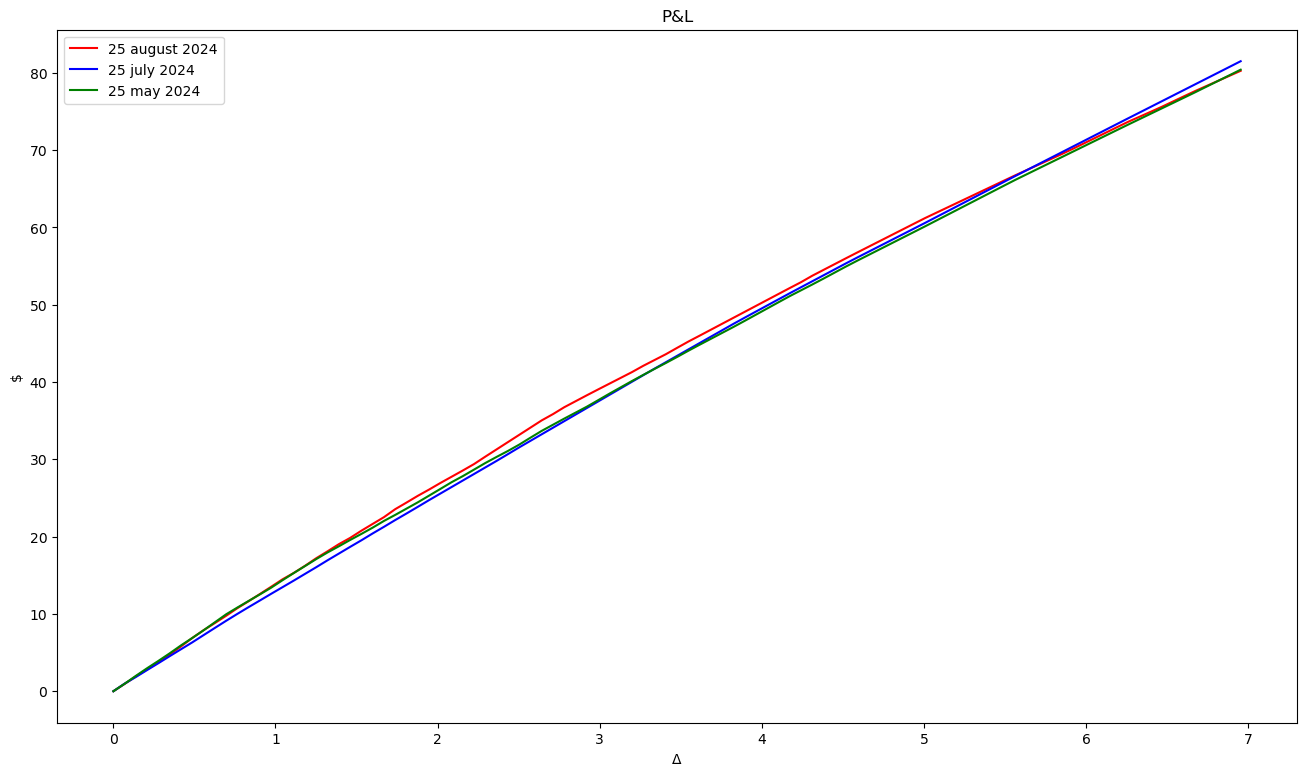

In [61]:
plt.plot(buys,output_vals1[:,0]+output_vals1[:,1]+output_vals1[:,2]+output_vals1[:,3], color='red',label="25 august 2024")
plt.plot(buys,output_vals2[:,0]+output_vals2[:,1]+output_vals2[:,2]+output_vals2[:,3], color='blue',label="25 july 2024")
plt.plot(buys,output_vals3[:,0]+output_vals3[:,1]+output_vals3[:,2]+output_vals3[:,3], color='green',label="25 may 2024")
plt.title("P&L")
plt.ylabel("\$")
plt.xlabel("$\Delta$")
plt.legend()
plt.savefig('pnl_sys_vol_low_cost_mr.pdf')

In [62]:
%%time


eta1 = 0.1

buys = np.array([100*i*dt for i in range(0,101)])
sells = np.array([-100*i*dt for i in range(0,101)])

output_vals1 = Parallel(n_jobs=6)(
    delayed(simulation_realprice)(N, T, dt, pa_0, buys[j], sells[j], noise, eta0, eta1, X, Y) for j in tqdm(range(len(buys)))
)
output_vals2 = Parallel(n_jobs=6)(
    delayed(simulation_realprice)(N, T, dt, pa_1, buys[j], sells[j], noise, eta0, eta1, X, Y) for j in tqdm(range(len(buys)))
)
output_vals3 = Parallel(n_jobs=6)(
    delayed(simulation_realprice)(N, T, dt, pa_2, buys[j], sells[j], noise, eta0, eta1, X, Y) for j in tqdm(range(len(buys)))
)

100%|███████████████████████████████████████████████████████████████████████████████████| 101/101 [00:03<00:00, 25.98it/s]


CPU times: user 1.39 s, sys: 92.5 ms, total: 1.48 s
Wall time: 13.6 s


In [63]:
output_vals1 = np.array(output_vals1)
output_vals2 = np.array(output_vals2)
output_vals3 = np.array(output_vals3)

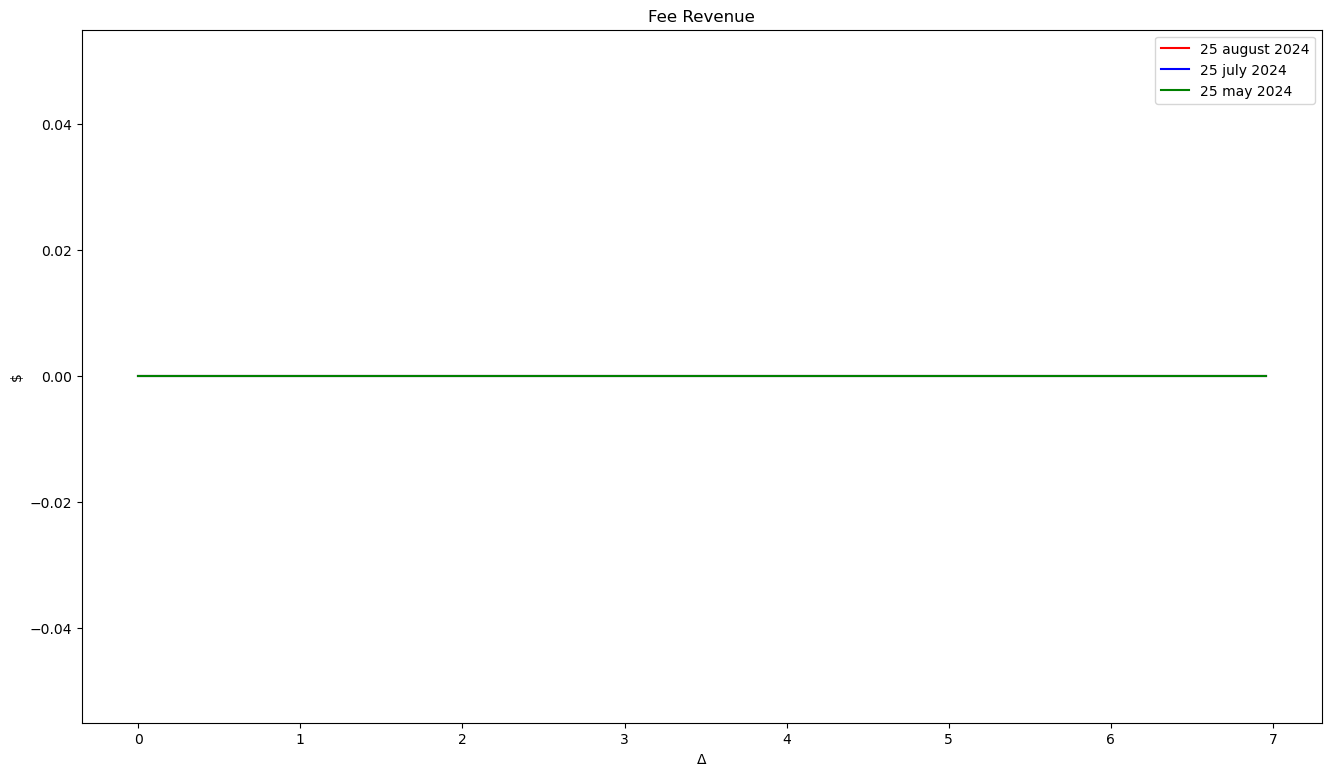

In [64]:
plt.plot(buys,output_vals1[:,0]+output_vals1[:,1]+output_vals1[:,2], color='red',label="25 august 2024")
plt.plot(buys,output_vals2[:,0]+output_vals2[:,1]+output_vals2[:,2], color='blue',label="25 july 2024")
plt.plot(buys,output_vals3[:,0]+output_vals3[:,1]+output_vals3[:,2], color='green',label="25 may 2024")
plt.title("Fee Revenue")
plt.ylabel("\$")
plt.xlabel("$\Delta$")
plt.legend()
plt.savefig('fee_rev_sys_vol_high_cost_mr.pdf')

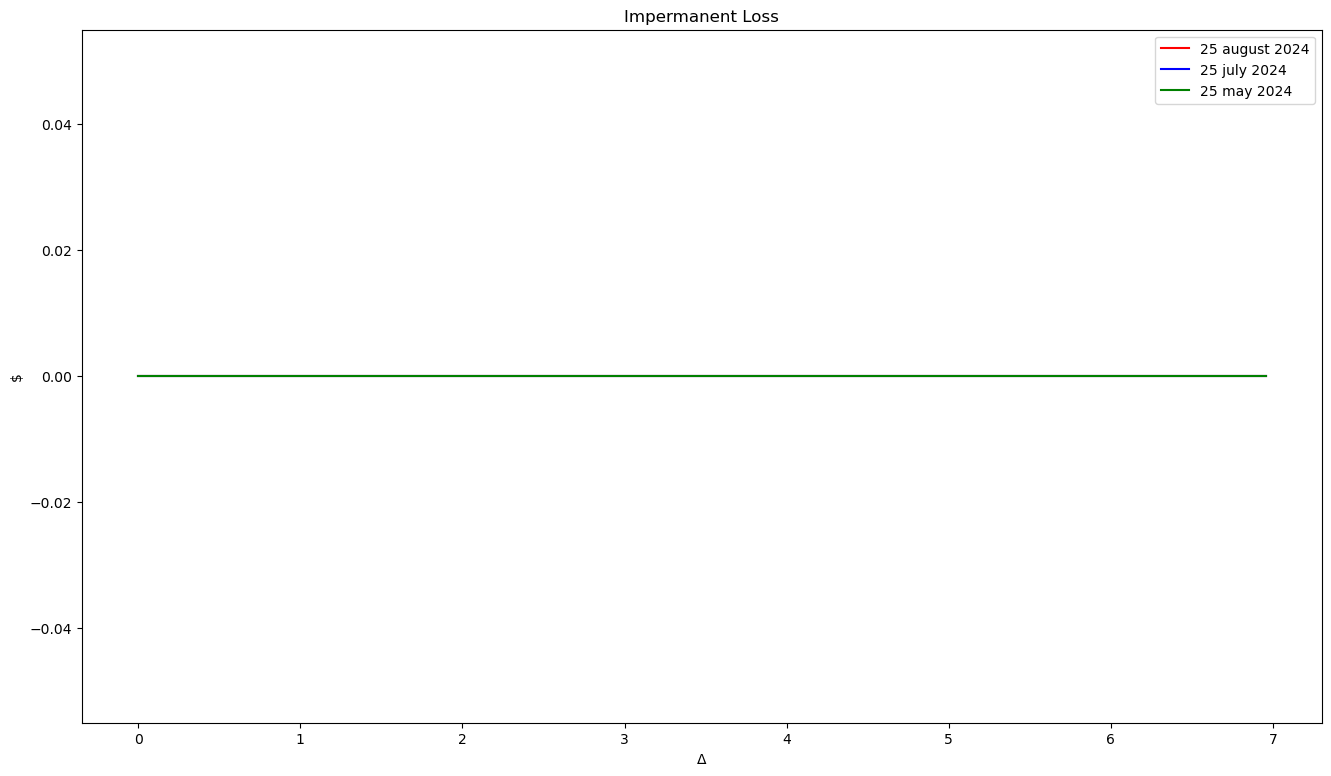

In [66]:
plt.plot(buys,output_vals1[:,3], color='red',label="25 august 2024")
plt.plot(buys,output_vals2[:,3], color='blue',label="25 july 2024")
plt.plot(buys,output_vals3[:,3], color='green',label="25 may 2024")
plt.title("Impermanent Loss")
plt.ylabel("\$")
plt.xlabel("$\Delta$")
plt.legend()
plt.savefig('imp_loss_sys_vol_high_cost_mr.pdf')

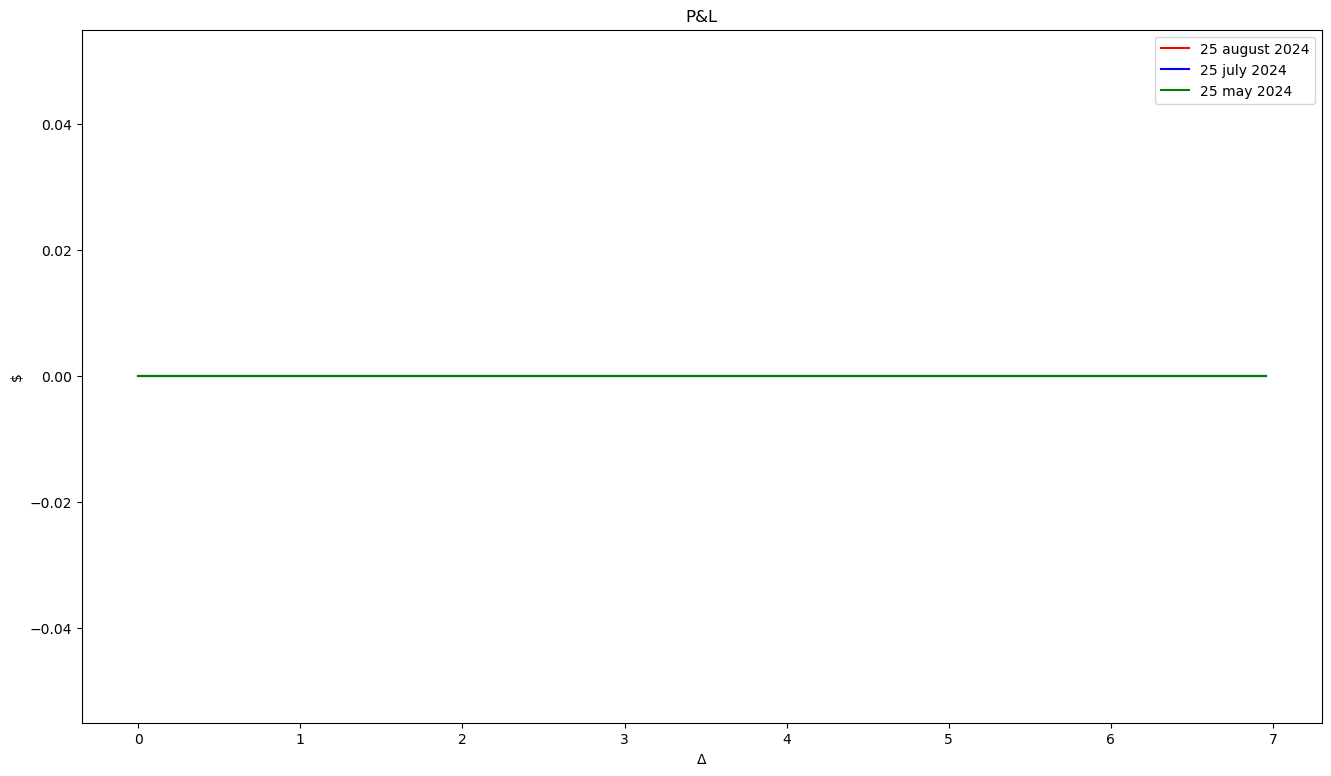

In [67]:
plt.plot(buys,output_vals1[:,0]+output_vals1[:,1]+output_vals1[:,2]+output_vals1[:,3], color='red',label="25 august 2024")
plt.plot(buys,output_vals2[:,0]+output_vals2[:,1]+output_vals2[:,2]+output_vals2[:,3], color='blue',label="25 july 2024")
plt.plot(buys,output_vals3[:,0]+output_vals3[:,1]+output_vals3[:,2]+output_vals3[:,3], color='green',label="25 may 2024")
plt.title("P&L")
plt.ylabel("\$")
plt.xlabel("$\Delta$")
plt.legend()
plt.savefig('pnl_sys_vol_high_cost_mr.pdf')